# Final Project Machine Learning - Tommaso Mingrone

Description of the original dataset from kaggle: https://www.kaggle.com/datasets/unclesamulus/blood-cells-image-dataset


The dataset contains a total of 17,092 images of individual normal cells, which were acquired using the analyzer CellaVision DM96 in the Core Laboratory at the Hospital Clinic of Barcelona. The dataset is organized in the following eight groups: neutrophils, eosinophils, basophils, lymphocytes, monocytes, immature granulocytes (promyelocytes, myelocytes, and metamyelocytes), erythroblasts and platelets or thrombocytes. The size of the images is 360 x 363 pixels, in format JPG, and they were annotated by expert clinical pathologists. The images were captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection.

This high-quality labelled dataset may be used to train and test machine learning and deep learning models to recognize different types of normal peripheral blood cells. To our knowledge, this is the first publicly available set with large numbers of normal peripheral blood cells, so that it is expected to be a canonical dataset for model benchmarking.

![DatasetImagePresentation](https://storage.googleapis.com/kaggle-datasets-images/2277635/3865189/405d3eefedd5bbc96b9a918d7295f749/dataset-cover.jpg?t=2022-06-27-06-23-38)



### Purpose of my project:

* Classifying images of white blood cells of healthy individuals

#### Complementary:

* Studying the structure of the data
* Find the most efficient classification method

## Data processing

In [ ]:
# Import system libraries
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# Import data management tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import MiniBatchKMeans 

# Import deep learning libraries
from time import time
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import torchvision.transforms as transforms 
from sklearn import metrics  


In [ ]:
from google.colab import files
files.upload()  # Load the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tommasomingrone","key":"45467c7e53405f377e1778ad1cde2161"}'}

In [ ]:
import zipfile

# Create the .kaggle directory and move the kaggle.json file into it
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Set permissions for the kaggle.json file
os.chmod("/root/.kaggle/kaggle.json", 600)

# Download dataset from Kaggle
!kaggle datasets download -d unclesamulus/blood-cells-image-dataset

# Estrai il dataset
with zipfile.ZipFile("blood-cells-image-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("blood-cells-image-dataset")

# Verify that the files have been extracted correctly
os.listdir("blood-cells-image-dataset")

Dataset URL: https://www.kaggle.com/datasets/unclesamulus/blood-cells-image-dataset
License(s): CC-BY-SA-4.0
 99% 265M/268M [00:03<00:00, 81.1MB/s]
100% 268M/268M [00:03<00:00, 76.7MB/s]


['bloodcells_dataset']

In [ ]:
# List of extracted files
dataset_dir = "blood-cells-image-dataset"
for root, dirs, files in os.walk(dataset_dir):
    for name in files:
        print(os.path.join(root, name))

Output streaming troncato alle ultime 5000 righe.
blood-cells-image-dataset/bloodcells_dataset/neutrophil/SNE_341311.jpg
blood-cells-image-dataset/bloodcells_dataset/neutrophil/SNE_495849.jpg
blood-cells-image-dataset/bloodcells_dataset/neutrophil/SNE_574534.jpg
blood-cells-image-dataset/bloodcells_dataset/neutrophil/SNE_402177.jpg
blood-cells-image-dataset/bloodcells_dataset/neutrophil/SNE_184726.jpg
blood-cells-image-dataset/bloodcells_dataset/neutrophil/BNE_436871.jpg
blood-cells-image-dataset/bloodcells_dataset/neutrophil/SNE_10898.jpg
blood-cells-image-dataset/bloodcells_dataset/neutrophil/BNE_436393.jpg
blood-cells-image-dataset/bloodcells_dataset/neutrophil/BNE_389215.jpg
blood-cells-image-dataset/bloodcells_dataset/neutrophil/SNE_993408.jpg
blood-cells-image-dataset/bloodcells_dataset/neutrophil/BNE_818755.jpg
blood-cells-image-dataset/bloodcells_dataset/neutrophil/SNE_248543.jpg
blood-cells-image-dataset/bloodcells_dataset/neutrophil/SNE_183003.jpg
blood-cells-image-dataset/bl

In [ ]:
# Function to load and preprocess images
def load_and_preprocess_images(dataset_dir, target_size):
    images = []
    labels = []
    label_mapping = {}
    reverse_label_mapping = {}

    for class_dir in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_dir)
        if os.path.isdir(class_path):
            if class_dir not in label_mapping:
                label_mapping[class_dir] = len(label_mapping)
                reverse_label_mapping[len(reverse_label_mapping)] = class_dir
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img_resized = cv2.resize(img, target_size)
                    img_flat = img_resized.flatten().astype(float) / 255.
                    images.append(img_flat)
                    labels.append(label_mapping[class_dir])
                else:
                    print(f"Image {img_name} could not be loaded.")

    if not images:
        raise ValueError("No images were loaded. Check the dataset directory and image paths.")

    X = np.array(images)
    y = np.array(labels)

    return X, y, reverse_label_mapping

# Function to filter out unwanted classes
def filter_classes(X, y, reverse_label_mapping, classes_to_remove):
    # Create a new reverse_label_mapping without the classes to be removed
    filtered_reverse_label_mapping = {i: label for i, label in reverse_label_mapping.items() if label not in classes_to_remove}

    # Image indexes to be maintained
    keep_indices = [i for i, label in enumerate(y) if reverse_label_mapping[label] not in classes_to_remove]

    X_filtered = X[keep_indices]
    y_filtered = y[keep_indices]

    # Convert numeric labels to names
    y_filtered_names = [reverse_label_mapping[label] for label in y_filtered]

    return X_filtered, y_filtered_names, y_filtered, filtered_reverse_label_mapping

# Define the path to the dataset
dataset_dir = '/content/blood-cells-image-dataset/bloodcells_dataset'

# Define target size
target_size = (64, 64)

# Carica il dataset
X, y, reverse_label_mapping = load_and_preprocess_images(dataset_dir, target_size)


# Define the classes to be removed
classes_to_remove = ['ig', 'platelet', 'erythroblast']

# Filter out unwanted classes
X_filtered, y_filtered_names, y_filtered, new_reverse_label_mapping = filter_classes(X, y, reverse_label_mapping, classes_to_remove)

# View some information
print(f"Numero di immagini dopo il filtro: {X_filtered.shape[0]}")
print(f"Dimensione di ogni immagine (flattened): {X_filtered.shape[1]}")
print(f"Nuove etichette disponibili: {new_reverse_label_mapping}")


Numero di immagini dopo il filtro: 10298
Dimensione di ogni immagine (flattened): 12288
Nuove etichette disponibili: {3: 'monocyte', 4: 'lymphocyte', 5: 'basophil', 6: 'neutrophil', 7: 'eosinophil'}


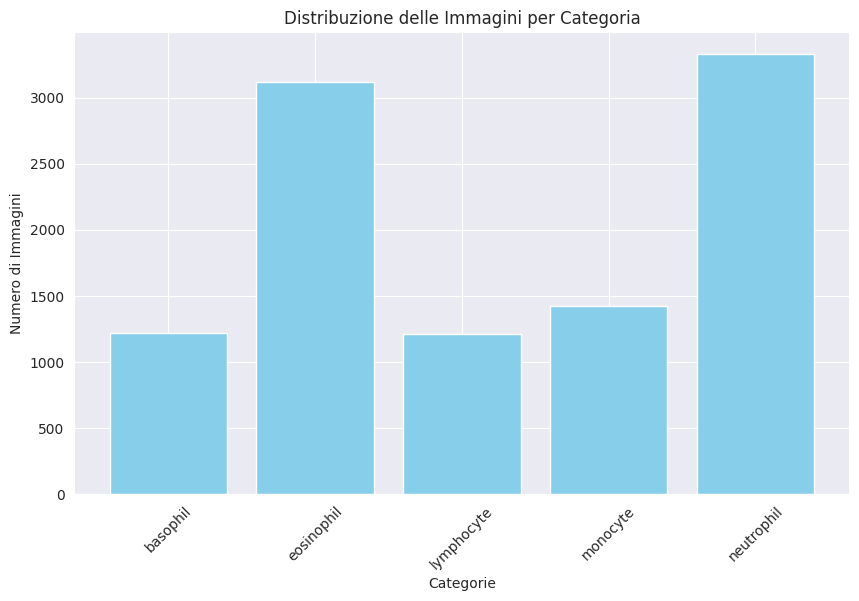

In [ ]:
# Count the number of images per category
unique, counts = np.unique(y_filtered_names, return_counts=True)
category_counts = dict(zip(unique, counts))

# Plot of image distribution by category
categories = list(category_counts.keys())
counts = list(category_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Categorie')
plt.ylabel('Numero di Immagini')
plt.title('Distribuzione delle Immagini per Categoria')
plt.xticks(rotation=45)
plt.show()

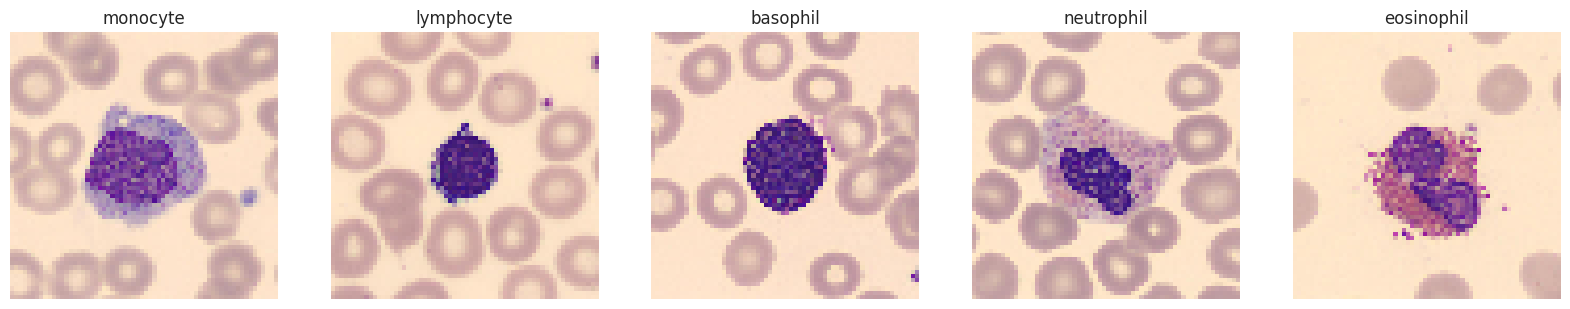

In [ ]:
# Display an image for each category
fig, axs = plt.subplots(1, len(new_reverse_label_mapping), figsize=(20, 5))
for i, label in enumerate(new_reverse_label_mapping.values()):
    ax = axs[i]
    img_index = np.where(np.array(y_filtered_names) == label)[0][0]
    img = X_filtered[img_index].reshape(target_size[0], target_size[1], 3)

    img = img[..., ::-1]

    ax.imshow(img) 
    ax.set_title(f'{label}')
    ax.axis('off')
plt.show()


In [ ]:
import numpy as np

def standardize_data(X):

    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_standardized = (X - mean) / std
    return X_standardized, mean, std

# Standardize data
X_standardized, mean, std = standardize_data(X_filtered)

print(f"Forma dei dati standardizzati: {X_standardized.shape}")
print(f"Media dei dati standardizzati (prima della standardizzazione): {mean[:5]}")  
print(f"Deviazione standard dei dati standardizzati (prima della standardizzazione): {std[:5]}")


Forma dei dati standardizzati: (10298, 12288)
Media dei dati standardizzati (prima della standardizzazione): [0.73329144 0.79297751 0.91300576 0.73325679 0.79246189]
Deviazione standard dei dati standardizzati (prima della standardizzazione): [0.06688238 0.11367385 0.09265859 0.06637753 0.11431982]


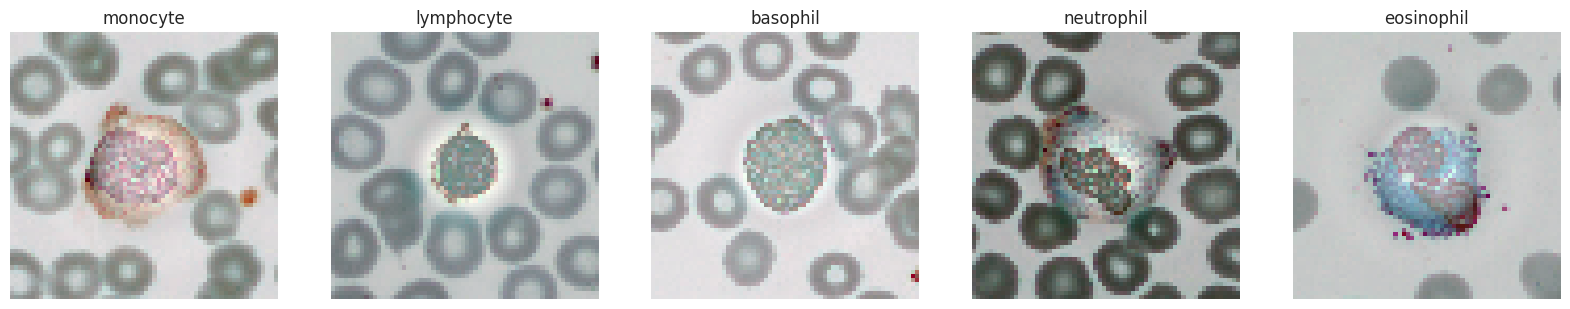

In [ ]:
import matplotlib.pyplot as plt

# Function to display standardized images
def visualize_standardized_images(X_standardized, y_filtered_names, new_reverse_label_mapping, target_size):
    fig, axs = plt.subplots(1, len(new_reverse_label_mapping), figsize=(20, 5))
    for i, label in enumerate(new_reverse_label_mapping.values()):
        ax = axs[i]
        img_index = np.where(np.array(y_filtered_names) == label)[0][0]
        img_standardized = X_standardized[img_index].reshape(target_size[0], target_size[1], 3) 

        img_standardized = (img_standardized - img_standardized.min()) / (img_standardized.max() - img_standardized.min())

        ax.imshow(img_standardized)
        ax.set_title(f'{label}')
        ax.axis('off')
    plt.show()

visualize_standardized_images(X_standardized, y_filtered_names, new_reverse_label_mapping, target_size)


In [ ]:
# Create a DataFrame with data and labels
df = pd.DataFrame({'images': list(X_filtered), 'labels': y_filtered})

# Split the dataset into training, validation and test set
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)

# Verify the size of the sets
print(f'Training set size: {len(train_df)}')
print(f'Test set size: {len(test_df)}')
print(f'Validation set size: {len(valid_df)}')

# Extracting images and labels from DataFrames
X_train = np.vstack(train_df['images'].values)
y_train = train_df['labels'].values.astype(int)  

X_valid = np.vstack(valid_df['images'].values)
y_valid = valid_df['labels'].values.astype(int)  

X_test = np.vstack(test_df['images'].values)
y_test = test_df['labels'].values.astype(int)  

Training set size: 6590
Test set size: 2060
Validation set size: 1648


## Unsupervised learning

- K-means

In [ ]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans

# Number of clusters based on the number of unique labels
n_digits = len(np.unique(y_filtered))
print(f"Number of clusters (digits): {n_digits}")

# Initialize KMeans template
kmeans = MiniBatchKMeans(n_clusters=n_digits, n_init=10, random_state=42)

# Train the model on the training data
kmeans.fit(X_filtered)


Number of clusters (digits): 5


MiniBatchKMeans(n_clusters=5, n_init=10, random_state=42)

In [ ]:
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from scipy.stats import mode

# Function to calculate metrics
def calculate_metrics(estimator, data, labels):
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

# List of different cluster numbers to be tested
clusters = [5]

# Variables to keep track of the best pattern
best_accuracy = 0
best_n_clusters = 0
best_kmeans = None

# Assume that X_filtered and y_filtered are already defined and pre-processed

# Test different numbers of clusters
for n_clusters in clusters:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(X_filtered)

    # Calculate metrics on training data
    calculate_metrics(kmeans, X_filtered, y_filtered)
    predicted_y_train = kmeans.predict(X_filtered)
    accuracy = metrics.accuracy_score(y_filtered, predicted_y_train)
    print('Training Accuracy: {}\n'.format(accuracy))

    # Update the best model if the current accuracy is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_clusters = n_clusters
        best_kmeans = kmeans

print(f'Best number of clusters: {best_n_clusters} with accuracy: {best_accuracy}')


Number of Clusters: 5
Inertia: 1505557.4804638866
Homogeneity: 0.2585929130951666
Training Accuracy: 0.02534472713148184

Best number of clusters: 5 with accuracy: 0.02534472713148184


In [ ]:
if best_kmeans is not None:
    # Predict clusters on test data
    test_clusters = best_kmeans.predict(X_test)

    # Calculate accuracy on test data
    test_accuracy = metrics.accuracy_score(y_test, test_clusters)
    print('Test Accuracy: {}\n'.format(test_accuracy))

    # Print predicted and actual labels for comparison
    print("Predicted labels (first 20):", test_clusters[:30])
    print("Actual labels (first 20)  .:", y_test[:30])

else:
    print("No best KMeans model found. Please run the training phase first.")

Test Accuracy: 0.029611650485436892

Predicted labels (first 20): [4 0 2 3 1 4 4 0 0 4 0 2 4 3 2 2 3 0 0 4 1 1 4 2 3 3 0 0 3 1]
Actual labels (first 20)  .: [5 5 6 7 3 7 3 6 4 6 4 6 7 6 6 6 7 6 4 3 7 3 3 6 7 6 4 6 7 3]


In [ ]:
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns

# Define function to map clusters to real labels
def map_clusters_to_labels(kmeans_labels, y, n_digits):
    labels = np.zeros_like(kmeans_labels)
    for i in range(n_digits):
        mask = (kmeans_labels == i)
        labels[mask] = mode(y[mask], keepdims=True)[0][0]
    return labels


# Function to calculate metrics
def calculate_metrics(estimator, data, labels):
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

# List of different cluster numbers to be tested
clusters = [5]

# Variables to keep track of the best pattern
best_accuracy = 0
best_n_clusters = 0
best_kmeans = None

# Test different numbers of clusters
for n_clusters in clusters:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(X_filtered)

    calculate_metrics(kmeans, X_filtered, y_filtered)
    predicted_y_train = kmeans.predict(X_filtered)

    # Mapping clusters to actual labels.
    mapped_y_train = map_clusters_to_labels(predicted_y_train, y_filtered, n_clusters)

    accuracy = metrics.accuracy_score(y_filtered, mapped_y_train)
    print('Training Accuracy: {}\n'.format(accuracy))
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_clusters = n_clusters
        best_kmeans = kmeans

print(f'Best number of clusters: {best_n_clusters} with accuracy: {best_accuracy}')



Number of Clusters: 5
Inertia: 1505557.4804638866
Homogeneity: 0.2585929130951666
Training Accuracy: 0.5637016896484754

Best number of clusters: 5 with accuracy: 0.5637016896484754


In [ ]:
from sklearn import metrics

if best_kmeans is not None:

    test_clusters = best_kmeans.predict(X_test)

   
    unique, counts = np.unique(test_clusters, return_counts=True)
    print("Distribution of predicted clusters in the test data:", dict(zip(unique, counts)))

    # Mapping clusters to actual labels
    mapped_y_test = map_clusters_to_labels(test_clusters, y_test, best_n_clusters)

    # Create a dictionary mapping between clusters and labels
    cluster_to_label = {}
    for i in range(best_n_clusters):
        cluster_mask = (test_clusters == i)
        if np.any(cluster_mask):
            most_common_label = mode(y_test[cluster_mask], keepdims=True)[0][0]
            cluster_to_label[i] = most_common_label

    # All labels are represented in the colors
    all_labels = np.unique(y)
    new_palette = sns.color_palette("Paired", len(all_labels))
    label_colors = {label: color for label, color in zip(all_labels, new_palette)}

    for i in range(best_n_clusters):
        cluster_mask = (test_clusters == i)
        if np.any(cluster_mask):
            most_common_label = mode(y_test[cluster_mask], keepdims=True)[0][0]
            label_counts = np.bincount(y_test[cluster_mask])
            print(f"Cluster {i} (count: {np.sum(cluster_mask)}): Mapped to label {most_common_label}")
            print(f"Label distribution in cluster {i}: {label_counts}")

    # Calculate accuracy on test data
    test_accuracy = metrics.accuracy_score(y_test, mapped_y_test)
    print('Test Accuracy: {}\n'.format(test_accuracy))

    # Print predicted and actual labels for comparison
    print("Predicted labels (first 20):", mapped_y_test[:100])
    print("Actual labels (first 20)  .:", y_test[:100])


Distribuzione dei cluster predetti nei dati di test: {0: 364, 1: 153, 2: 500, 3: 547, 4: 496}
Cluster 0 (count: 364): Mapped to label 4
Label distribution in cluster 0: [  0   0   0   1 210  36 100  17]
Cluster 1 (count: 153): Mapped to label 3
Label distribution in cluster 1: [ 0  0  0 69  3 15 18 48]
Cluster 2 (count: 500): Mapped to label 6
Label distribution in cluster 2: [  0   0   0   8  23  15 390  64]
Cluster 3 (count: 547): Mapped to label 7
Label distribution in cluster 3: [  0   0   0  61   7 117  90 272]
Cluster 4 (count: 496): Mapped to label 7
Label distribution in cluster 4: [  0   0   0 145   0  61  68 222]
Test Accuracy: 0.5645631067961165

Predicted labels (first 20): [7 4 6 7 3 7 7 4 4 7 4 6 7 7 6 6 7 4 4 7 3 3 7 6 7 7 4 4 7 3 7 7 7 7 7 4 4
 4 6 6 7 6 6 7 6 6 4 4 7 7 7 4 7 7 3 4 7 7 4 7 7 4 7 6 7 7 4 4 6 4 7 7 3 6
 6 7 6 7 6 4 6 6 6 7 4 7 6 7 3 6 3 7 6 3 7 4 6 4 6 6]
Actual labels (first 20)  .: [5 5 6 7 3 7 3 6 4 6 4 6 7 6 6 6 7 6 4 3 7 3 3 6 7 6 4 6 7 3 4 7 6 6 7 4

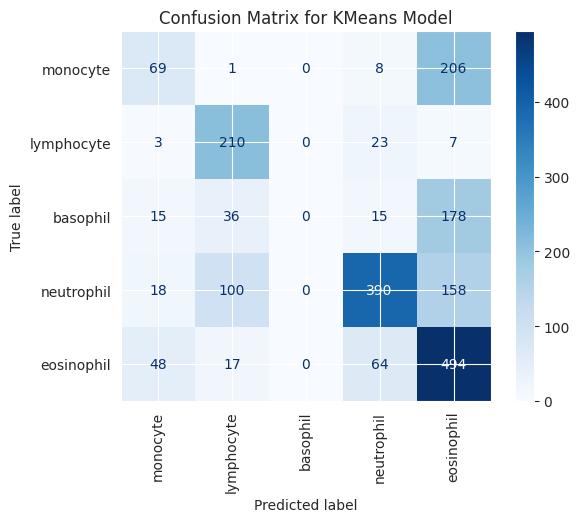

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import mode
# Calculate confusion matrix
cm = confusion_matrix(y_test, mapped_y_test, labels=np.unique(y_filtered))

# Confusion matrix visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[new_reverse_label_mapping[i] for i in np.unique(y_filtered)])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Confusion Matrix for KMeans Model")
plt.show()

- PCA

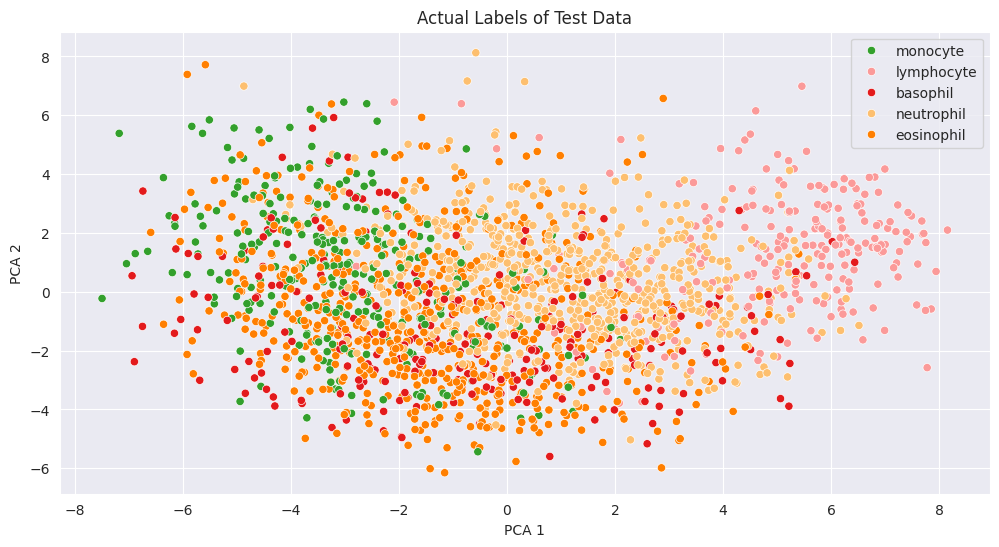

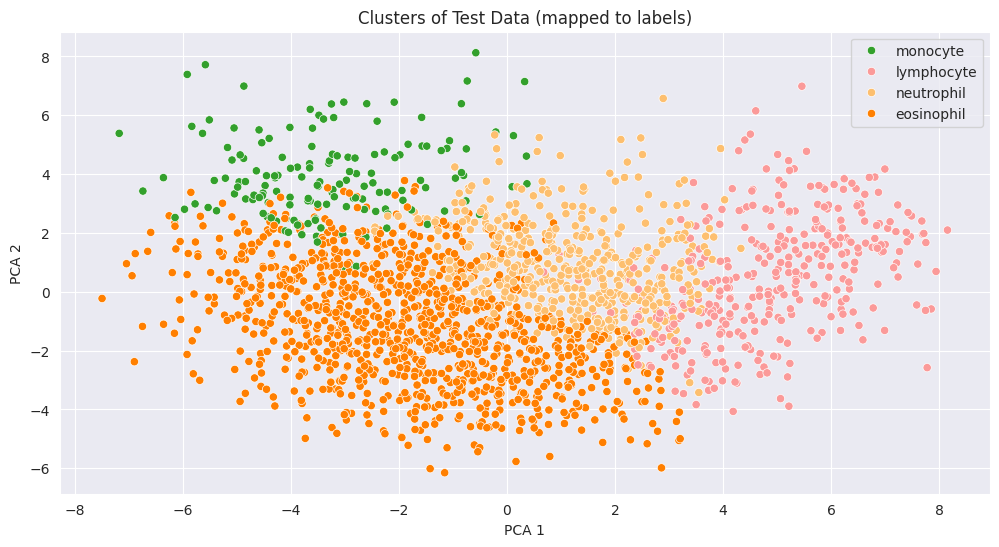

In [ ]:
from sklearn.decomposition import PCA
# Reduce data to two dimensions
pca = PCA(2)
reduced_data = pca.fit_transform(X_test)


cluster_colors = [label_colors[cluster_to_label[cluster]] for cluster in test_clusters]

# Plot of test data with actual labels
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=y_test, palette=label_colors, legend='full')
plt.title('Actual Labels of Test Data')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
handles, labels = scatter.get_legend_handles_labels()
new_labels = [new_reverse_label_mapping[int(label)] for label in labels]
plt.legend(handles, new_labels)
plt.show()

# Plot of test data with predicted labels
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=[cluster_to_label[cluster] for cluster in test_clusters], palette=label_colors, legend='full')
plt.title('Clusters of Test Data (mapped to labels)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
handles, labels = scatter.get_legend_handles_labels()
new_labels = [new_reverse_label_mapping[int(label)] for label in labels]
plt.legend(handles, new_labels)
plt.show()


The class of basophils, in the 2D graph, does not form a well-defined cluster, but rather they are scattered. Since clusters were mapped with the label most present in the data that belong to the mapped cluster, the class of basophils is in no case the most present class. So with this method, the label for basophils will never be predicted since there is no starting mapped cluster.

* Kernel PCA

In [ ]:
from sklearn.decomposition import KernelPCA
# Function to define Kernel PCA
def kernel_pca(X, n_components=2, kernel='rbf'):
    kpca = KernelPCA(n_components=n_components, kernel=kernel)
    X_kpca = kpca.fit_transform(X)
    return X_kpca


In [ ]:
X_test_kpca = kernel_pca(X_test, n_components=2)

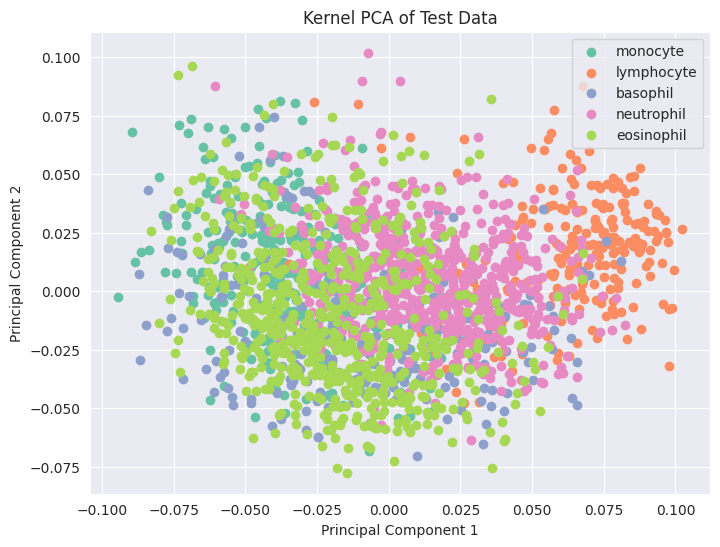

In [ ]:
# Display data
all_labels = np.unique(y_test)
new_palette = sns.color_palette("Set2", len(all_labels))

plt.figure(figsize=(8, 6))
for i, label in enumerate(all_labels):
    plt.scatter(X_test_kpca[y_test == label, 0], X_test_kpca[y_test == label, 1],
                label=new_reverse_label_mapping[label], color=new_palette[i])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Kernel PCA of Test Data')
plt.legend()
plt.show()

In [ ]:
X_test_kpca_3d = kernel_pca(X_test, n_components=3)

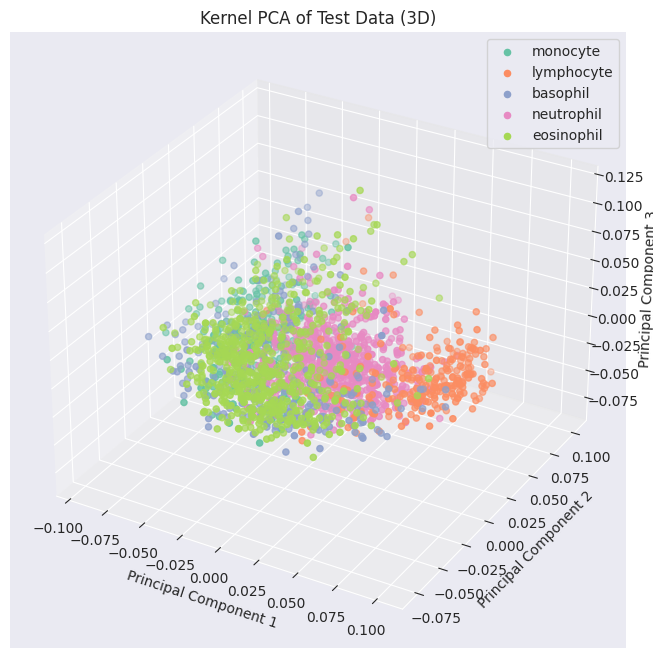

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(all_labels):
    ax.scatter(X_test_kpca_3d[y_test == label, 0], X_test_kpca_3d[y_test == label, 1],
               X_test_kpca_3d[y_test == label, 2], label=new_reverse_label_mapping[label], color=new_palette[i])

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Kernel PCA of Test Data (3D)')
plt.legend()
plt.show()

## Supervised learning

Train e Stratidied K-fold Cross Validation

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Configure Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameters to search for RandomForestClassifier
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Define parameters to search for KNeighborsClassifier
knn_param_grid = {
    'n_neighbors': [3, 5],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Function to perform Grid Search with K-Fold Cross Validation
def cross_validate_model(model, param_grid, model_name, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters for {model_name}: {best_params}")
    print(f"Best cross-validation accuracy for {model_name}: {best_score}")

    return best_model, best_params, best_score

# Function to display the confusion matrix
def display_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"{model_name} Classification Report:\n{classification_report(y_test, y_pred)}")

    labels = [new_reverse_label_mapping[i] for i in np.unique(y_test)]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


* Test


K-Nearest Neighbors
Best parameters for K-Nearest Neighbors: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Best cross-validation accuracy for K-Nearest Neighbors: 0.7345978755690441
K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           3       0.67      0.60      0.63       284
           4       0.67      0.86      0.75       243
           5       0.64      0.40      0.49       244
           6       0.92      0.73      0.82       666
           7       0.67      0.87      0.76       623

    accuracy                           0.73      2060
   macro avg       0.71      0.69      0.69      2060
weighted avg       0.75      0.73      0.73      2060



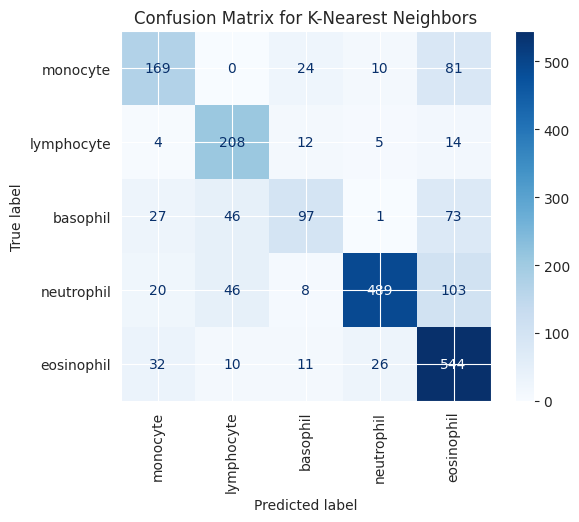

In [ ]:
print("\nK-Nearest Neighbors")
best_knn_model, best_knn_params, best_knn_accuracy = cross_validate_model(KNeighborsClassifier(), knn_param_grid, "K-Nearest Neighbors", X_train, y_train)
display_confusion_matrix(best_knn_model, X_test, y_test, "K-Nearest Neighbors")

Random Forest
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy for Random Forest: 0.9001517450682852
Random Forest Classification Report:
              precision    recall  f1-score   support

           3       0.90      0.87      0.89       284
           4       0.87      0.91      0.89       243
           5       0.87      0.71      0.78       244
           6       0.92      0.97      0.95       666
           7       0.94      0.96      0.95       623

    accuracy                           0.91      2060
   macro avg       0.90      0.88      0.89      2060
weighted avg       0.91      0.91      0.91      2060



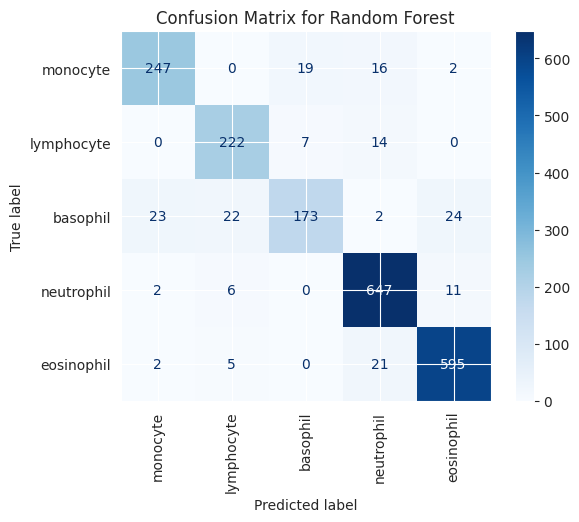

In [ ]:
print("Random Forest")
best_rf_model, best_rf_params, best_rf_accuracy = cross_validate_model(RandomForestClassifier(), rf_param_grid, "Random Forest", X_train, y_train)
display_confusion_matrix(best_rf_model, X_test, y_test, "Random Forest")

* Gaussian Naive Bayes)


Gaussian Naive Bayes Classification Report (Train Data):
               precision    recall  f1-score   support

           3       0.60      0.73      0.66       909
           4       0.82      0.89      0.85       777
           5       0.66      0.68      0.67       779
           6       0.91      0.88      0.89      2130
           7       0.87      0.76      0.81      1995

    accuracy                           0.80      6590
   macro avg       0.77      0.79      0.78      6590
weighted avg       0.81      0.80      0.80      6590



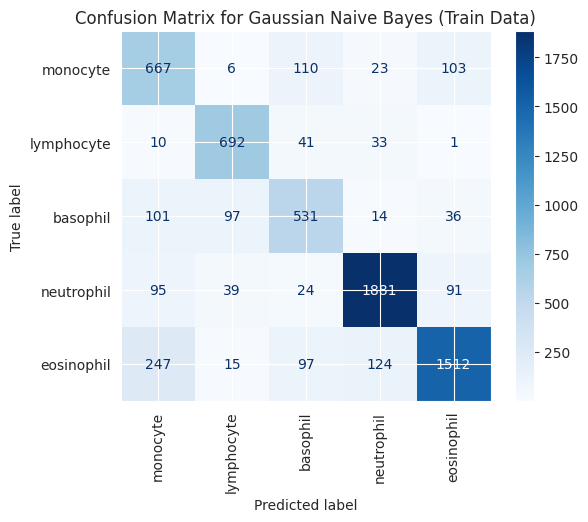

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Training the Gaussian Naive Bayes model
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

# Making predictions
y_pred = gnb_model.predict(X_train)

# Display the confusion matrix
cm = confusion_matrix(y_train, y_pred)
print("Gaussian Naive Bayes Classification Report (Train Data):\n", classification_report(y_train, y_pred))
labels = [new_reverse_label_mapping[i] for i in np.unique(y_train)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Confusion Matrix for Gaussian Naive Bayes (Train Data)")
plt.show()


Gaussian Naive Bayes Classification Report (Test Data):
               precision    recall  f1-score   support

           3       0.59      0.71      0.64       284
           4       0.81      0.89      0.85       243
           5       0.65      0.68      0.66       244
           6       0.89      0.89      0.89       666
           7       0.86      0.73      0.79       623

    accuracy                           0.79      2060
   macro avg       0.76      0.78      0.77      2060
weighted avg       0.80      0.79      0.79      2060



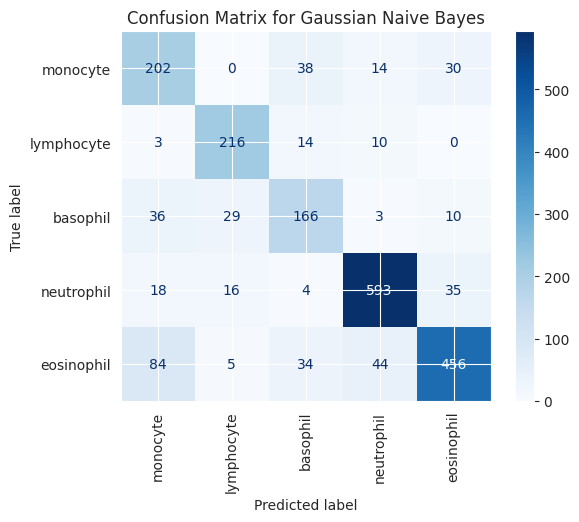

In [ ]:
# Making the predictions on test data
y_pred_test = gnb_model.predict(X_test)

cm_test = confusion_matrix(y_test, y_pred_test)
print("Gaussian Naive Bayes Classification Report (Test Data):\n", classification_report(y_test, y_pred_test))
labels = [new_reverse_label_mapping[i] for i in np.unique(y_test)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Confusion Matrix for Gaussian Naive Bayes")
plt.show()

* Adaboost

AdaBoost Classification Report (Test Data):
               precision    recall  f1-score   support

           3       0.78      0.83      0.80       284
           4       0.84      0.84      0.84       243
           5       0.62      0.66      0.64       244
           6       0.91      0.94      0.93       666
           7       0.94      0.86      0.90       623

    accuracy                           0.86      2060
   macro avg       0.82      0.82      0.82      2060
weighted avg       0.86      0.86      0.86      2060



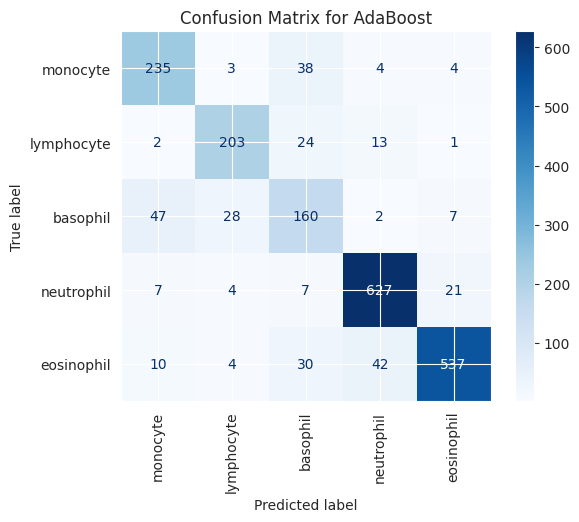

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Training the AdaBoost model on training data
ada_model = AdaBoostClassifier(n_estimators=100)
ada_model.fit(X_train, y_train)

# Making the predictions on test data
y_pred_test = ada_model.predict(X_test)


cm_test = confusion_matrix(y_test, y_pred_test)
print("AdaBoost Classification Report (Test Data):\n", classification_report(y_test, y_pred_test))
labels = [new_reverse_label_mapping[i] for i in np.unique(y_test)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Confusion Matrix for AdaBoost")
plt.show()


## SVM multiclass



*   Low dimensionality




In [ ]:
from sklearn.decomposition import PCA
# Reducing dimensionality with PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_valid_pca = pca.transform(X_valid)

In [ ]:
from sklearn.svm import SVC
# Train the multiclass SVM model on dimensionally reduced data
svmLinear = SVC(kernel='linear', decision_function_shape='ovo', random_state=42)  # 'ovo' stands for One-vs-One
svmLinear.fit(X_train_pca, y_train)

# Evaluate the SVM model on dimensionally reduced test data
y_test_pred_svm = svmLinear.predict(X_test_pca)
print("SVM Test Accuracy:", accuracy_score(y_test, y_test_pred_svm))
print("SVM Test Classification Report:\n", classification_report(y_test, y_test_pred_svm))

# Evaluate the SVM model on dimensionally reduced validation data
y_val_pred_svm = svmLinear.predict(X_valid_pca)
print("SVM Validation Accuracy:", accuracy_score(y_valid, y_val_pred_svm))
print("SVM Validation Classification Report:\n", classification_report(y_valid, y_val_pred_svm))

SVM Test Accuracy: 0.5723300970873786
SVM Test Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.26      0.34       284
           2       0.78      0.70      0.74       243
           4       0.00      0.00      0.00       244
           6       0.60      0.79      0.68       666
           7       0.50      0.66      0.57       623

    accuracy                           0.57      2060
   macro avg       0.47      0.48      0.47      2060
weighted avg       0.50      0.57      0.53      2060



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM Validation Accuracy: 0.5813106796116505
SVM Validation Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.31      0.40       227
           2       0.72      0.68      0.70       194
           4       0.00      0.00      0.00       195
           6       0.63      0.76      0.68       533
           7       0.51      0.71      0.59       499

    accuracy                           0.58      1648
   macro avg       0.48      0.49      0.48      1648
weighted avg       0.52      0.58      0.54      1648



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


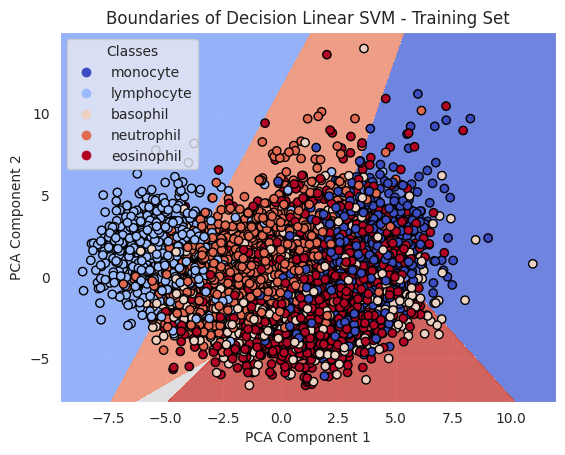

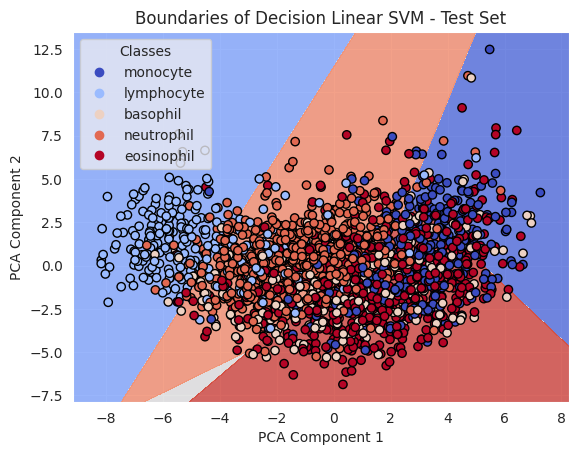

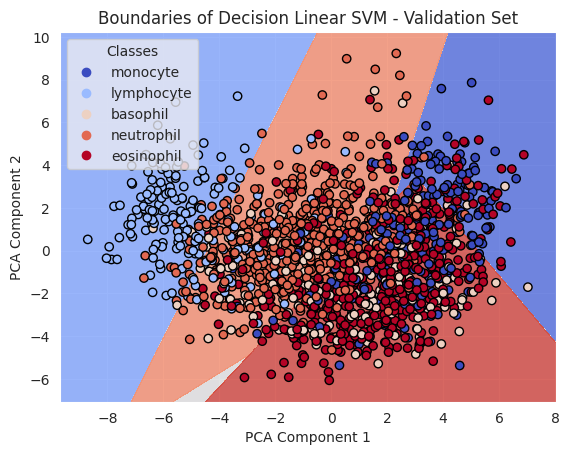

In [ ]:
# Visualization of decision boundaries
def plot_decision_boundaries(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(title)

    handles, _ = scatter.legend_elements(prop="colors")
    labels = [new_reverse_label_mapping[i] for i in np.unique(y_filtered)]
    plt.legend(handles, labels, title="Classes")

    plt.show()


plot_decision_boundaries(X_train_pca, y_train, svmLinear, "Boundaries of Decision Linear SVM - Training Set")
plot_decision_boundaries(X_test_pca, y_test, svmLinear, "Boundaries of Decision Linear SVM - Test Set")
plot_decision_boundaries(X_valid_pca, y_valid, svmLinear, "Boundaries of Decision Linear SVM - Validation Set")

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
# Train multiclass SVM model and rbf kernel on dimensionally reduced data
svmGaussian = SVC(kernel='rbf', decision_function_shape='ovo', random_state=42)  
svmGaussian.fit(X_train_pca, y_train)

# Evaluate the SVM model on dimensionally reduced test data
y_test_pred_svm = svmGaussian.predict(X_test_pca)
print("SVM Gaussian Test Accuracy:", accuracy_score(y_test, y_test_pred_svm))
print("SVM Gaussian Test Classification Report:\n", classification_report(y_test, y_test_pred_svm))

# Evaluate the SVM model on the dimensionally reduced validation data
y_val_pred_svm = svmGaussian.predict(X_valid_pca)
print("SVM Gaussian Validation Accuracy:", accuracy_score(y_valid, y_val_pred_svm))
print("SVM Gaussian Validation Classification Report:\n", classification_report(y_valid, y_val_pred_svm))

SVM Test Accuracy: 0.579126213592233
SVM Test Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.39      0.42       284
           2       0.83      0.67      0.74       243
           4       0.50      0.00      0.01       244
           6       0.60      0.83      0.70       666
           7       0.52      0.58      0.55       623

    accuracy                           0.58      2060
   macro avg       0.58      0.50      0.48      2060
weighted avg       0.57      0.58      0.54      2060

SVM Validation Accuracy: 0.5983009708737864
SVM Validation Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.43      0.46       227
           2       0.79      0.66      0.72       194
           4       1.00      0.02      0.03       195
           6       0.62      0.81      0.70       533
           7       0.55      0.65      0.59       499

    accuracy                    

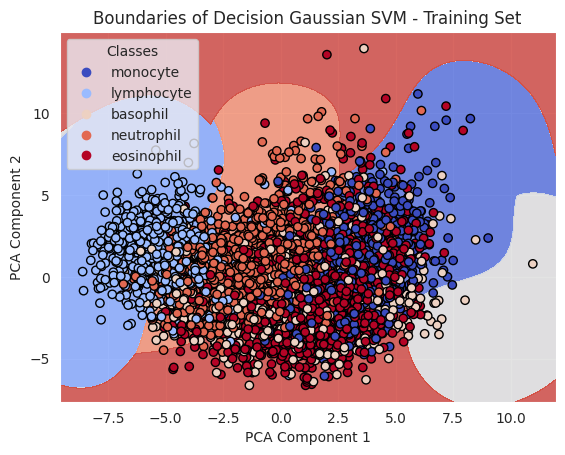

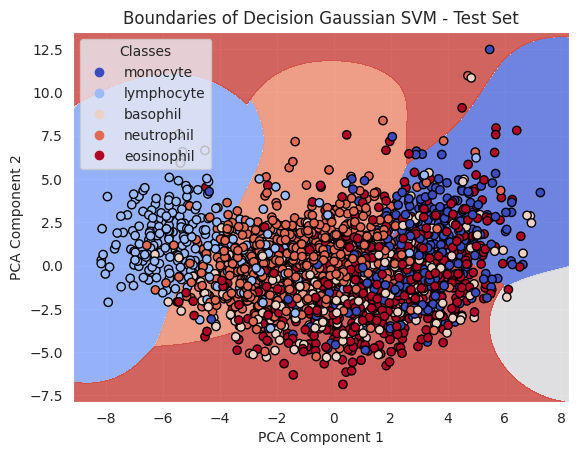

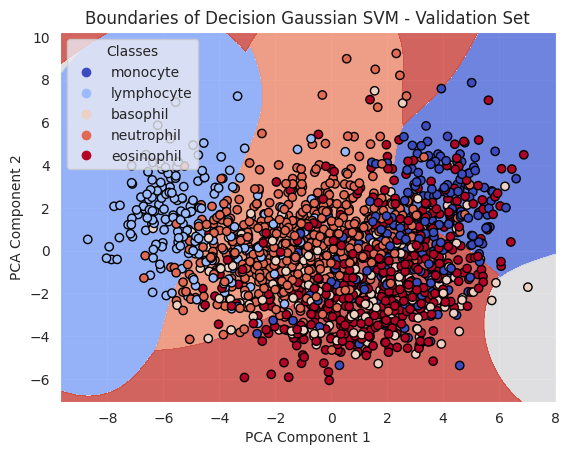

In [ ]:
# Visualization of decision boundaries
def plot_decision_boundaries(X, y, model, title, label_mapping):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(title)

    handles, _ = scatter.legend_elements(prop="colors")
    labels = [new_reverse_label_mapping[i] for i in np.unique(y_filtered)]
    plt.legend(handles, labels, title="Classes")

    plt.show()

plot_decision_boundaries(X_train_pca, y_train, svmGaussian, "Boundaries of Decision Gaussian SVM - Training Set", new_reverse_label_mapping)
plot_decision_boundaries(X_test_pca, y_test, svmGaussian, "Boundaries of Decision Gaussian SVM - Test Set", new_reverse_label_mapping)
plot_decision_boundaries(X_valid_pca, y_valid, svmGaussian, "Boundaries of Decision Gaussian SVM - Validation Set", new_reverse_label_mapping)

In [ ]:
# Train the multiclass SVM model on dimensionally reduced data
svmPoly = SVC(kernel='poly', decision_function_shape='ovo', random_state=42)  
svmPoly.fit(X_train_pca, y_train)

# Evaluate the SVM model on dimensionally reduced test data
y_test_pred_svm = svmPoly.predict(X_test_pca)
print("SVM Test Accuracy:", accuracy_score(y_test, y_test_pred_svm))
print("SVM Test Classification Report:\n", classification_report(y_test, y_test_pred_svm))

# Evaluate the SVM model on dimensionally reduced validation data
y_val_pred_svm = svmPoly.predict(X_valid_pca)
print("SVM Validation Accuracy:", accuracy_score(y_valid, y_val_pred_svm))
print("SVM Validation Classification Report:\n", classification_report(y_valid, y_val_pred_svm))

SVM Test Accuracy: 0.5422330097087379
SVM Test Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.20      0.26       284
           2       0.84      0.67      0.74       243
           4       0.00      0.00      0.00       244
           6       0.51      0.91      0.65       666
           7       0.55      0.47      0.51       623

    accuracy                           0.54      2060
   macro avg       0.46      0.45      0.43      2060
weighted avg       0.48      0.54      0.49      2060



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM Validation Accuracy: 0.5661407766990292
SVM Validation Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.28      0.38       227
           2       0.79      0.66      0.72       194
           4       0.00      0.00      0.00       195
           6       0.53      0.90      0.66       533
           7       0.56      0.52      0.54       499

    accuracy                           0.57      1648
   macro avg       0.49      0.47      0.46      1648
weighted avg       0.51      0.57      0.52      1648



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
# Train the multiclass SVM model on dimensionally reduced data
svmSigmoidal = SVC(kernel='sigmoid', decision_function_shape='ovo', random_state=42) 
svmSigmoidal.fit(X_train_pca, y_train)

# Evaluate the SVM model on dimensionally reduced test data
y_test_pred_svm = svmSigmoidal.predict(X_test_pca)
print("SVM Sigmoidal Test Accuracy:", accuracy_score(y_test, y_test_pred_svm))
print("SVM Sigmoidal Test Classification Report:\n", classification_report(y_test, y_test_pred_svm))

# Evaluate the SVM model on dimensionally reduced validation data
y_val_pred_svm = svmSigmoidal.predict(X_valid_pca)
print("SVM Sigmoidal Validation Accuracy:", accuracy_score(y_valid, y_val_pred_svm))
print("SVM Sigmoidal Validation Classification Report:\n", classification_report(y_valid, y_val_pred_svm))

SVM Sigmoidal Test Accuracy: 0.32524271844660196
SVM Sigmoidal Test Classification Report:
               precision    recall  f1-score   support

           2       0.28      0.45      0.34       284
           3       0.37      0.50      0.42       666
           4       0.26      0.08      0.12       244
           6       0.44      0.24      0.31       623
           7       0.14      0.16      0.15       243

    accuracy                           0.33      2060
   macro avg       0.30      0.29      0.27      2060
weighted avg       0.34      0.33      0.31      2060

SVM Sigmoidal Validation Accuracy: 0.3270631067961165
SVM Sigmoidal Validation Classification Report:
               precision    recall  f1-score   support

           2       0.28      0.47      0.35       227
           3       0.36      0.45      0.40       533
           4       0.18      0.05      0.08       195
           6       0.50      0.29      0.37       499
           7       0.15      0.20      0.17  



*   High dimensionality




SVM Test Accuracy: 0.9009708737864077
SVM Test Classification Report:
               precision    recall  f1-score   support

           2       0.85      0.88      0.87       284
           3       0.92      0.94      0.93       666
           4       0.81      0.79      0.80       244
           6       0.95      0.92      0.94       623
           7       0.86      0.90      0.88       243

    accuracy                           0.90      2060
   macro avg       0.88      0.88      0.88      2060
weighted avg       0.90      0.90      0.90      2060



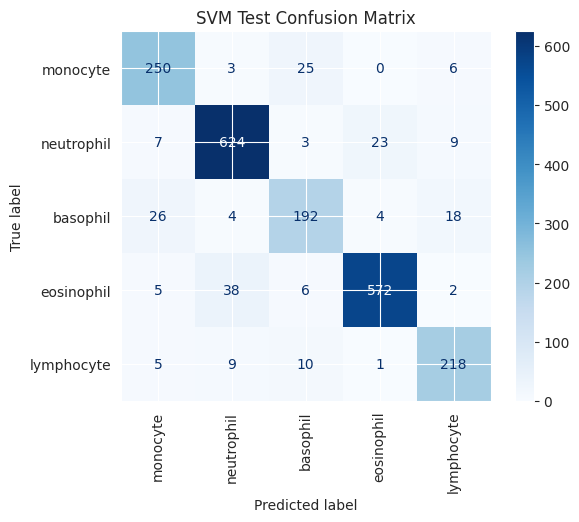

SVM Validation Accuracy: 0.8944174757281553
SVM Validation Classification Report:
               precision    recall  f1-score   support

           2       0.84      0.89      0.86       227
           3       0.91      0.93      0.92       533
           4       0.78      0.76      0.77       195
           6       0.95      0.91      0.93       499
           7       0.91      0.91      0.91       194

    accuracy                           0.89      1648
   macro avg       0.88      0.88      0.88      1648
weighted avg       0.90      0.89      0.89      1648



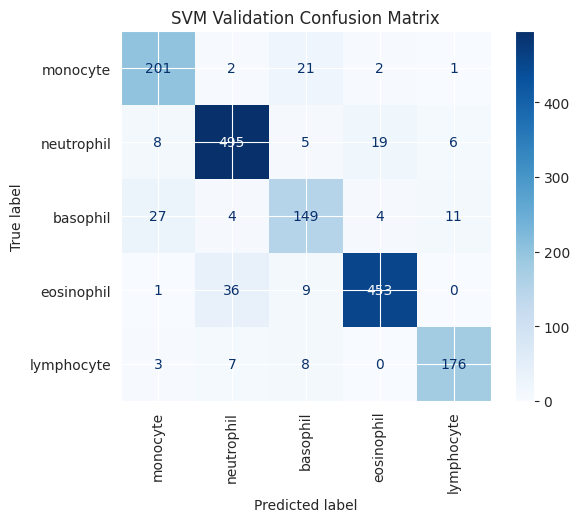

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Train the multiclass SVM model
svmLinear = SVC(kernel='linear', decision_function_shape='ovo', random_state=42) 
svmLinear.fit(X_train, y_train)

# Evaluate the SVM model on test data
y_test_pred_svm = svmLinear.predict(X_test)
print("SVM Test Accuracy:", accuracy_score(y_test, y_test_pred_svm))
print("SVM Test Classification Report:\n", classification_report(y_test, y_test_pred_svm))
test_cm_svm = confusion_matrix(y_test, y_test_pred_svm)

# Confusion matrix display for test data
labels = np.unique(y_test) 
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm_svm, display_labels=[new_reverse_label_mapping[i] for i in np.unique(y_filtered)])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("SVM Test Confusion Matrix")
plt.show()

# Evaluate the SVM model on the validation data
y_val_pred_svm = svmLinear.predict(X_valid)
print("SVM Validation Accuracy:", accuracy_score(y_valid, y_val_pred_svm))
print("SVM Validation Classification Report:\n", classification_report(y_valid, y_val_pred_svm))
val_cm_svm = confusion_matrix(y_valid, y_val_pred_svm)

# Confusion matrix display for validation data
labels = np.unique(y_valid) 
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm_svm, display_labels=[new_reverse_label_mapping[i] for i in np.unique(y_filtered)])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("SVM Validation Confusion Matrix")
plt.show()


SVM Gaussian Test Accuracy: 0.8898058252427185
SVM Gaussian Test Classification Report:
               precision    recall  f1-score   support

           2       0.89      0.83      0.86       284
           3       0.90      0.94      0.92       666
           4       0.78      0.77      0.78       244
           6       0.93      0.92      0.93       623
           7       0.84      0.85      0.85       243

    accuracy                           0.89      2060
   macro avg       0.87      0.86      0.87      2060
weighted avg       0.89      0.89      0.89      2060



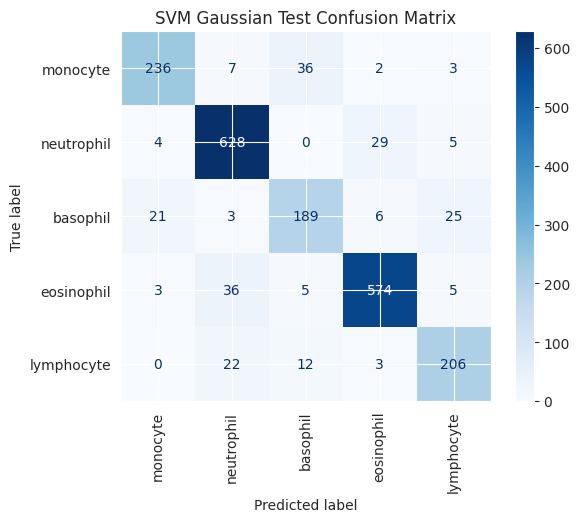

SVM Gaussian Validation Accuracy: 0.8962378640776699
SVM Gaussian Validation Classification Report:
               precision    recall  f1-score   support

           2       0.86      0.85      0.85       227
           3       0.90      0.95      0.92       533
           4       0.78      0.77      0.78       195
           6       0.95      0.92      0.94       499
           7       0.91      0.86      0.88       194

    accuracy                           0.90      1648
   macro avg       0.88      0.87      0.87      1648
weighted avg       0.90      0.90      0.90      1648



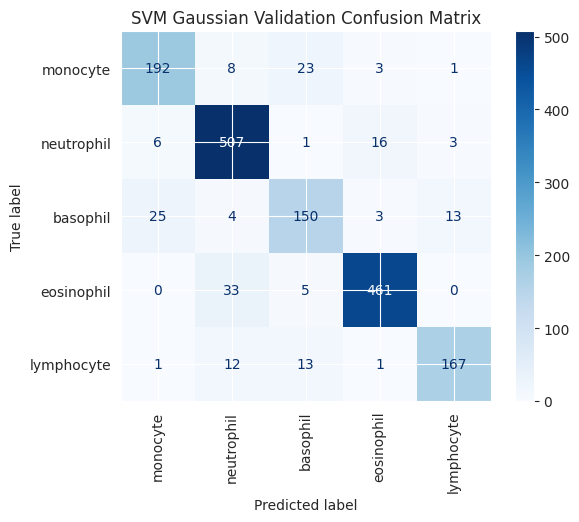

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Train the multiclass SVM model
svmGaussian = SVC(kernel='rbf', decision_function_shape='ovo', random_state=42)  
svmGaussian.fit(X_train, y_train)

# Evaluate the SVM model on test data
y_test_pred_svm = svmGaussian.predict(X_test)
print("SVM Gaussian Test Accuracy:", accuracy_score(y_test, y_test_pred_svm))
print("SVM Gaussian Test Classification Report:\n", classification_report(y_test, y_test_pred_svm))
test_cm_svm = confusion_matrix(y_test, y_test_pred_svm)
labels = np.unique(y_test)  
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm_svm, display_labels=[new_reverse_label_mapping[i] for i in np.unique(y_filtered)])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("SVM Gaussian Test Confusion Matrix")
plt.show()

# Evaluate the SVM model on the validation data
y_val_pred_svm = svmGaussian.predict(X_valid)
print("SVM Gaussian Validation Accuracy:", accuracy_score(y_valid, y_val_pred_svm))
print("SVM Gaussian Validation Classification Report:\n", classification_report(y_valid, y_val_pred_svm))
val_cm_svm = confusion_matrix(y_valid, y_val_pred_svm)
labels = np.unique(y_valid) 
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm_svm, display_labels=[new_reverse_label_mapping[i] for i in np.unique(y_filtered)])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("SVM Gaussian Validation Confusion Matrix")
plt.show()


## Deep learning

In [ ]:
# Scattered label mapping to continuous labels
label_mapping = {3: 0, 4: 1, 5: 2, 6: 3, 7: 4}
num_classes = len(label_mapping)

def map_labels(labels, mapping):
    mapped_labels = []
    for label in labels:
        if label in mapping:
            mapped_labels.append(mapping[label])
        else:
            raise ValueError(f"Label {label} is not in the label_mapping.")
    return np.array(mapped_labels)

In [ ]:
from torchvision import transforms
import numpy as np

# Image size assuming it is color and has 3 channels
image_height = 64
image_width = 64
num_channels = 3

# Definition of transformations
data_transforms = transforms.Compose([
    transforms.Lambda(lambda x: np.array(x).reshape(image_height, image_width, num_channels)),  # Restructure to (H, W, C)
    transforms.ToTensor(),  # Converts to tensor and reorders to (C, H, W)
    transforms.Lambda(lambda x: x.float())  # Ensures that the tensor is of type float
])


In [ ]:
from torch.utils.data import DataLoader, Dataset
class BloodDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = map_labels(labels, label_mapping)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:

            image = np.array(image)
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [ ]:
from torch.utils.data import DataLoader
train_dataset = BloodDataset(X_train, y_train, transform=data_transforms)
valid_dataset = BloodDataset(X_valid, y_valid, transform=data_transforms)
test_dataset = BloodDataset(X_test, y_test, transform=data_transforms)


BATCH_SIZE = 32
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
class FC1ReLU(nn.Module):
    def __init__(self):
        super(FC1ReLU, self).__init__()
        self.fc1 = nn.Linear(64 * 64 * 3, num_classes) # Layer fully connected

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.fc1(x)
        x = F.relu(x)

        return x

In [ ]:
class FC3ReLU(nn.Module):
    def __init__(self):
        super(FC3ReLU, self).__init__()
        self.fc1 = nn.Linear(64 * 64 * 3, 128)  # First layer fully connected
        self.fc2 = nn.Linear(128, 128)          # Second layer fully connected
        self.fc3 = nn.Linear(128, num_classes)  # Third layer fully connected

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.fc1(x)
        x = F.relu(x)  # Applying ReLU after the first layer is fully connected
        x = self.fc2(x)
        x = F.relu(x)  # Applying ReLU after the second layer is fully connected
        x = self.fc3(x)

        return x

In [ ]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1) # Convolutional hidden layer
        self.fc1 = nn.Linear(8 * 64 * 64, 128) # First layer fully connected
        self.fc2 = nn.Linear(128, num_classes) # Second layer fully connected

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)  # First convolutional hidden layer
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1) # Second convolutional hidden layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1) # Third convolutional hidden layer
        self.fc1 = nn.Linear(16 * 64 * 64, 128) # First layer fully connected
        self.fc2 = nn.Linear(128, num_classes)  # Second layer fully connected

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Auxiliary functions

def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def compute_weight_norm(model):
    norm = 0.0
    for name, param in model.named_parameters():
      if "weight" in name:
        norm += torch.norm(param.data, p= 2)
    return norm.cpu().item()


def train_model(model, num_epochs, trainloader, criterion, optimizer):

    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Rich mac user
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model = model.to(device)

    losses = []
    accs = []

    norms = []

    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## Training step
        for i, (images, labels) in enumerate(trainloader):

            images = images.to(device)
            labels = labels.to(device)

            ## Forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## Update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)


        losses.append(train_running_loss / i)
        accs.append(train_acc/i)

        norms.append(compute_weight_norm(model))
        model.eval()
        print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}")

    return losses, accs, norms

In [ ]:
import torch.optim as optim

# List of models to be tested
models = {
    "CNN1": CNN1,
}

# List of optimizers to be tested
optimizers = {
    "Adam": optim.Adam,
    "SGD": optim.SGD,
    "RMSprop": optim.RMSprop
}

# Fixed learning rate
learning_rate = 0.001

# Number of epochs
epochs = 5

# Results for each optimizer
results = {}

# Cycle to test each optimizer
for optimizer_name, optimizer_class in optimizers.items():
    print(f"\nTraining with optimizer: {optimizer_name} and learning rate: {learning_rate}")
    model = model_class()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    # Train the model
    train_losses, train_accuracies, norms = train_model(model, epochs, trainloader, criterion, optimizer)

    # Save results
    results[optimizer_name] = {
        'train_loss': train_losses,
        'train_accuracy': train_accuracies,
        'weight_norm': norms
    }
    print(f"Optimizer: {optimizer_name}, Learning rate: {learning_rate} - Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%")

# Displaying the final results
print("\nFinal Results:")
for optimizer_name, metrics in results.items():
    print(f"Optimizer: {optimizer_name}, Learning rate: {learning_rate}")
    print(f"  Train Loss: {metrics['train_loss']}")
    print(f"  Train Accuracy: {metrics['train_accuracy']}")
    print(f"  Weight Norm: {metrics['weight_norm']}")


Training with optimizer: Adam and learning rate: 0.001
Epoch: 1 | Loss: 1.4387 | Train Accuracy: 42.3069 | Time: 18.37
Epoch: 2 | Loss: 0.7313 | Train Accuracy: 75.1453 | Time: 16.49
Epoch: 3 | Loss: 0.4941 | Train Accuracy: 83.7927 | Time: 15.86
Epoch: 4 | Loss: 0.3253 | Train Accuracy: 90.0447 | Time: 22.10
Epoch: 5 | Loss: 0.2089 | Train Accuracy: 94.2378 | Time: 22.94
Optimizer: Adam, Learning rate: 0.001 - Train Loss: 0.2089, Train Accuracy: 94.24%

Training with optimizer: SGD and learning rate: 0.001
Epoch: 1 | Loss: 1.5152 | Train Accuracy: 33.1270 | Time: 12.37
Epoch: 2 | Loss: 1.4879 | Train Accuracy: 38.2175 | Time: 9.55
Epoch: 3 | Loss: 1.4645 | Train Accuracy: 42.0224 | Time: 12.31
Epoch: 4 | Loss: 1.4293 | Train Accuracy: 46.9482 | Time: 9.76
Epoch: 5 | Loss: 1.3770 | Train Accuracy: 47.6850 | Time: 8.81
Optimizer: SGD, Learning rate: 0.001 - Train Loss: 1.3770, Train Accuracy: 47.68%

Training with optimizer: RMSprop and learning rate: 0.001
Epoch: 1 | Loss: 1.6823 | Tr

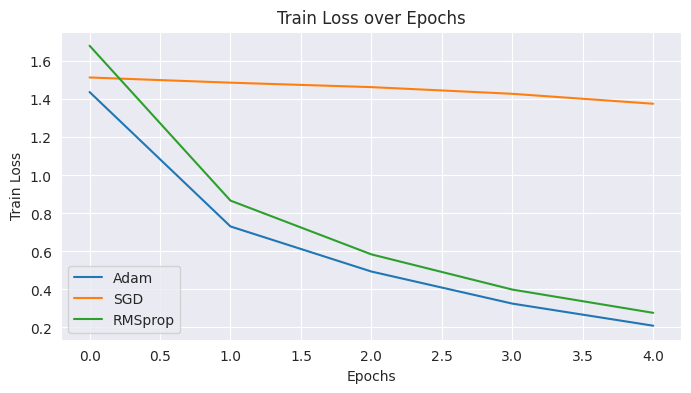

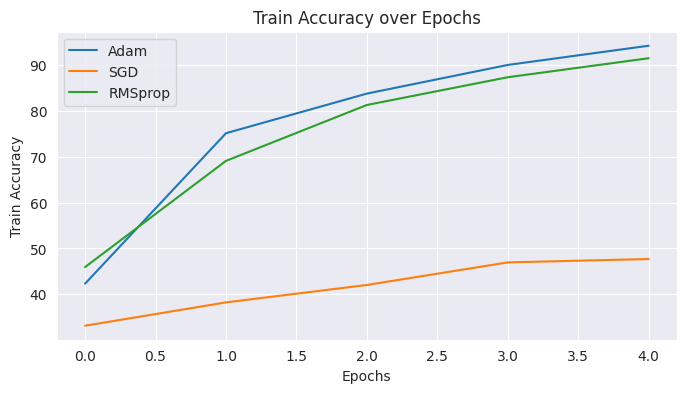

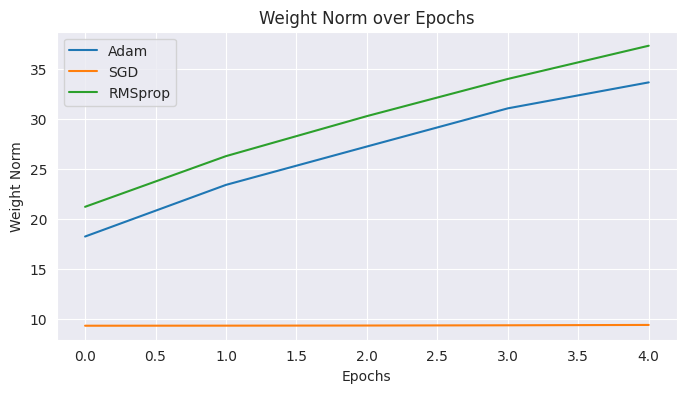

In [ ]:
# Plot of results
for metric in ['train_loss', 'train_accuracy', 'weight_norm']:
    plt.figure(figsize=(8, 4))
    for optimizer_name in results.keys():
        plt.plot(results[optimizer_name][metric], label=optimizer_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'{metric.replace("_", " ").title()} over Epochs')
    plt.legend()
    plt.show()

In [ ]:
trained_FC1ReLU = FC1ReLU()

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(trained_FC1ReLU.parameters(), lr=0.001)

train_losses_FC1ReLU, train_accuracies_FC1ReLU, W_adam = train_model(trained_FC1ReLU, 10, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 1.6556 | Train Accuracy: 13.9990 | Time: 2.91
Epoch: 2 | Loss: 1.6173 | Train Accuracy: 13.8608 | Time: 2.43
Epoch: 3 | Loss: 1.6173 | Train Accuracy: 13.8659 | Time: 2.60
Epoch: 4 | Loss: 1.6173 | Train Accuracy: 13.8618 | Time: 2.00
Epoch: 5 | Loss: 1.6173 | Train Accuracy: 13.8598 | Time: 2.13
Epoch: 6 | Loss: 1.6173 | Train Accuracy: 13.8608 | Time: 3.08
Epoch: 7 | Loss: 1.6173 | Train Accuracy: 13.8608 | Time: 2.68
Epoch: 8 | Loss: 1.6173 | Train Accuracy: 13.8577 | Time: 2.70
Epoch: 9 | Loss: 1.6173 | Train Accuracy: 13.8608 | Time: 4.56
Epoch: 10 | Loss: 1.6173 | Train Accuracy: 13.8608 | Time: 4.82


In [ ]:
trained_FC3ReLU = FC3ReLU()

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(trained_FC3ReLU.parameters(), lr=0.001)

train_losses_FC3ReLU, train_accuracies_FC3ReLU, W_adam = train_model(trained_FC3ReLU, 10, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 1.3196 | Train Accuracy: 45.2785 | Time: 14.13
Epoch: 2 | Loss: 0.8912 | Train Accuracy: 65.0671 | Time: 7.68
Epoch: 3 | Loss: 0.7796 | Train Accuracy: 70.3415 | Time: 10.21
Epoch: 4 | Loss: 0.6561 | Train Accuracy: 75.7541 | Time: 8.97
Epoch: 5 | Loss: 0.6273 | Train Accuracy: 76.4278 | Time: 7.58
Epoch: 6 | Loss: 0.5808 | Train Accuracy: 79.0203 | Time: 8.32
Epoch: 7 | Loss: 0.5435 | Train Accuracy: 80.5752 | Time: 7.45
Epoch: 8 | Loss: 0.5579 | Train Accuracy: 79.1728 | Time: 8.43
Epoch: 9 | Loss: 0.4885 | Train Accuracy: 81.8425 | Time: 7.96
Epoch: 10 | Loss: 0.4871 | Train Accuracy: 82.3120 | Time: 7.90


In [ ]:
trained_CNN1 = CNN1()

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(trained_CNN1.parameters(), lr=0.001)

train_losses_CNN1, train_accuracies_CNN1, W_adam = train_model(trained_CNN1, 10, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 1.2151 | Train Accuracy: 51.1321 | Time: 15.59
Epoch: 2 | Loss: 0.6103 | Train Accuracy: 78.8841 | Time: 17.56
Epoch: 3 | Loss: 0.4521 | Train Accuracy: 85.7114 | Time: 15.61
Epoch: 4 | Loss: 0.3095 | Train Accuracy: 90.9268 | Time: 21.31
Epoch: 5 | Loss: 0.2255 | Train Accuracy: 93.6880 | Time: 23.76
Epoch: 6 | Loss: 0.1836 | Train Accuracy: 94.5843 | Time: 21.82
Epoch: 7 | Loss: 0.1292 | Train Accuracy: 96.8720 | Time: 24.80
Epoch: 8 | Loss: 0.1018 | Train Accuracy: 97.5295 | Time: 22.66
Epoch: 9 | Loss: 0.0777 | Train Accuracy: 98.3994 | Time: 22.20
Epoch: 10 | Loss: 0.0561 | Train Accuracy: 98.9939 | Time: 23.14


In [ ]:
trained_CNN3 = CNN3()

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(trained_CNN3.parameters(), lr=0.001)

train_losses_CNN3, train_accuracies_CNN3, W_adam = train_model(trained_CNN3, 10, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 0.8584 | Train Accuracy: 67.2378 | Time: 47.24
Epoch: 2 | Loss: 0.2955 | Train Accuracy: 89.9512 | Time: 65.20
Epoch: 3 | Loss: 0.1809 | Train Accuracy: 94.5569 | Time: 49.03
Epoch: 4 | Loss: 0.1126 | Train Accuracy: 96.5843 | Time: 58.10
Epoch: 5 | Loss: 0.0712 | Train Accuracy: 98.2459 | Time: 57.43
Epoch: 6 | Loss: 0.0728 | Train Accuracy: 98.0640 | Time: 57.49
Epoch: 7 | Loss: 0.0479 | Train Accuracy: 98.8557 | Time: 58.15
Epoch: 8 | Loss: 0.0502 | Train Accuracy: 98.7652 | Time: 58.23
Epoch: 9 | Loss: 0.0541 | Train Accuracy: 98.6890 | Time: 58.05
Epoch: 10 | Loss: 0.0320 | Train Accuracy: 99.3598 | Time: 57.88


In [ ]:
# Dictionary of results
results = {
    "FC1ReLU": {
        "train_loss": train_losses_FC1ReLU,
        "train_accuracy": train_accuracies_FC1ReLU
    },
    "FC3ReLU": {
        "train_loss": train_losses_FC3ReLU,
        "train_accuracy": train_accuracies_FC3ReLU
    },
    "CNN1": {
        "train_loss": train_losses_CNN1,
        "train_accuracy": train_accuracies_CNN1
    },
    "CNN3": {
        "train_loss": train_losses_CNN3,
        "train_accuracy": train_accuracies_CNN3
    }
}

In [ ]:
def plot_results(results, model_names):
    plt.figure(figsize=(14, 6))
    Epoch = [0,1,2,3,4,5,6,7,8,9]
    # Plotting loss
    plt.subplot(1, 2, 1)
    for model_name in model_names:
        if model_name in results:
            metrics = results[model_name]
            plt.plot(metrics['train_loss'], label=f'{model_name} Train Loss')
    plt.title('Train Loss per Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(Epoch)

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    for model_name in model_names:
        if model_name in results:
            metrics = results[model_name]
            plt.plot(metrics['train_accuracy'], label=f'{model_name} Train Accuracy')
    plt.title('Train Accuracy per Model')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(Epoch)

    plt.tight_layout()
    plt.show()

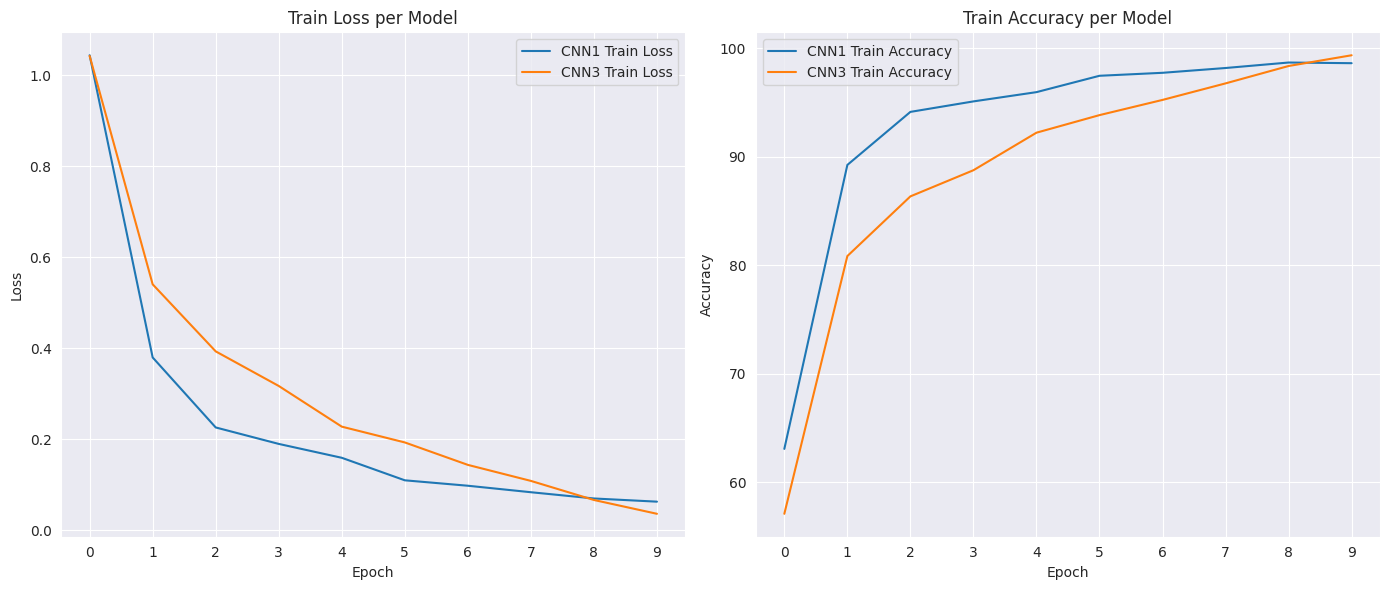

In [ ]:
models_to_plot = ["CNN1", "CNN3"]

plot_results(results, models_to_plot)

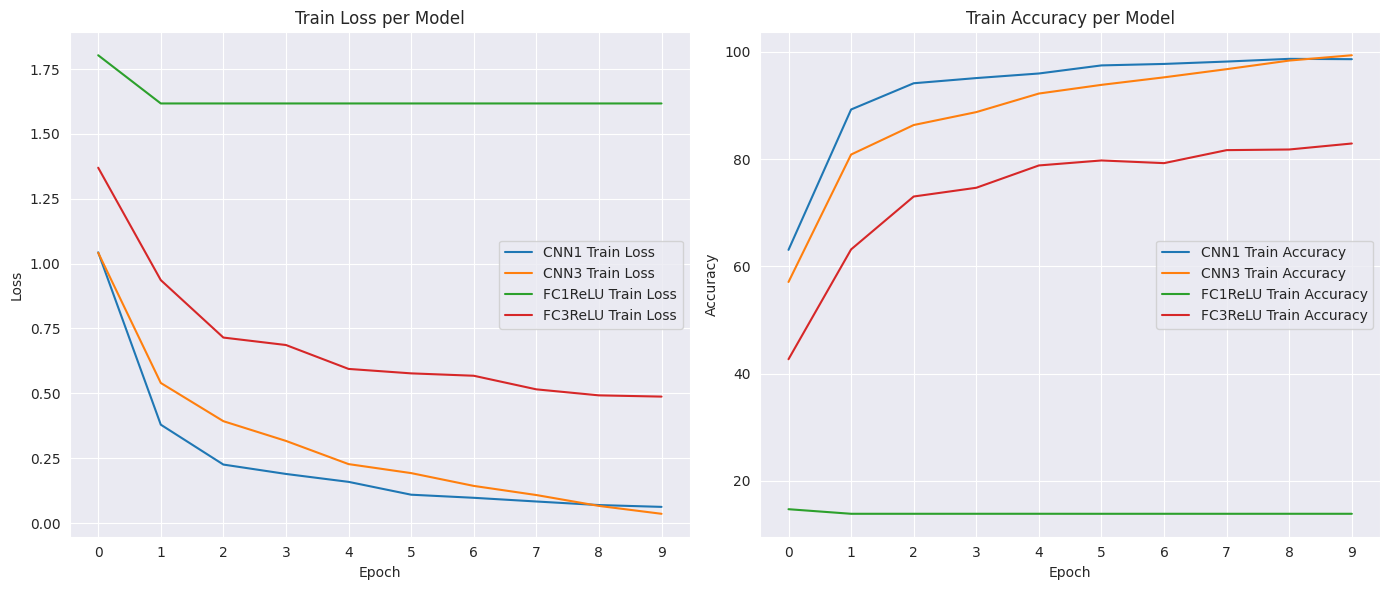

In [ ]:
models_to_plot = ["CNN1", "CNN3", "FC1ReLU", "FC3ReLU"]

plot_results(results, models_to_plot)

In [ ]:
# Function to evaluate the model on test data
def evaluate_model(model, testloader, criterion):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad(): 
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            test_loss += loss.item()
            test_acc += get_accuracy(logits, labels)

    test_loss /= len(testloader)
    test_acc /= len(testloader)

    return test_loss, test_acc


In [ ]:
# Function to obtain model predictions
def get_predictions(model, dataloader):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            _, preds = torch.max(logits, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

Evaluating FC1ReLU model on test data...


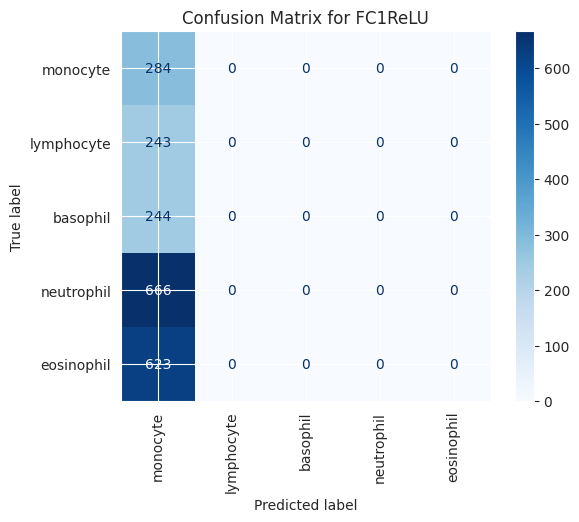

Evaluating FC3ReLU model on test data...


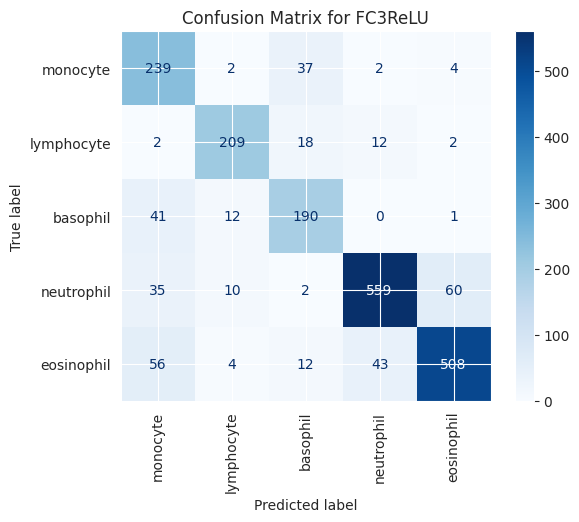

Evaluating CNN1 model on test data...


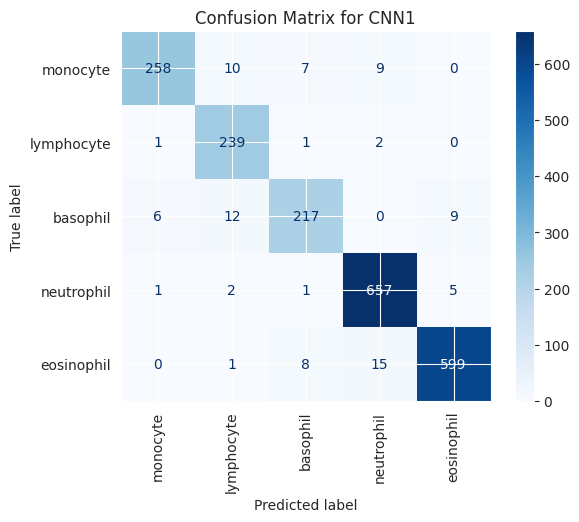

Evaluating CNN3 model on test data...


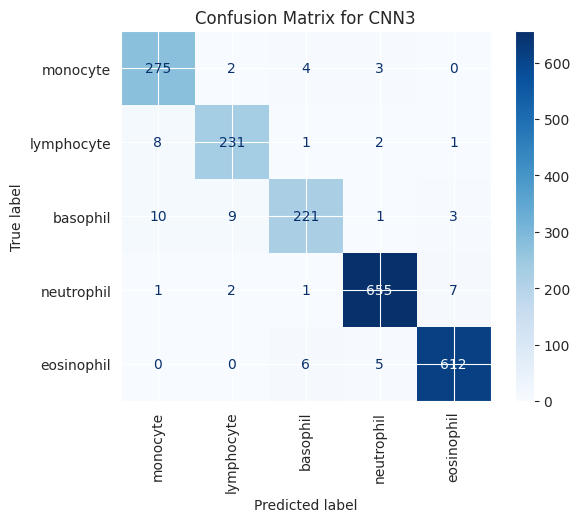


Model: FC1ReLU
Test Loss: 1.6094
Test Accuracy: 13.8141
Confusion Matrix:

Model: FC3ReLU
Test Loss: 0.4701
Test Accuracy: 82.9327
Confusion Matrix:

Model: CNN1
Test Loss: 0.1465
Test Accuracy: 95.6731
Confusion Matrix:

Model: CNN3
Test Loss: 0.1114
Test Accuracy: 96.8269
Confusion Matrix:


In [ ]:
# Perform the evaluation for each model
models = {
    "FC1ReLU": trained_FC1ReLU,
    "FC3ReLU": trained_FC3ReLU,
    "CNN1": trained_CNN1,
    "CNN3": trained_CNN3
}

results_test = {}

criterion = nn.CrossEntropyLoss()

for model_name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    print(f"Evaluating {model_name} model on test data...")
    test_loss, test_acc = evaluate_model(model, testloader, criterion)

    # Getting predictions and labels
    preds, labels = get_predictions(model, testloader)

    # Calculate the confusion matrix
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[new_reverse_label_mapping[i] for i in np.unique(y_filtered)])

    results_test[model_name] = {
        "test_loss": test_loss,
        "test_accuracy": test_acc,
    }

    # Visualize the confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xticks(rotation=90)
    plt.show()

# Print evaluation results on test data
for model_name, metrics in results_test.items():
    print(f"\nModel: {model_name}")
    print(f"Test Loss: {metrics['test_loss']:.4f}")
    print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
    print("Confusion Matrix:")

In [ ]:
def train_and_validate_model(model, trainloader, validloader, criterion, optimizer, epochs, device):
    model.to(device)
    train_results = {'accuracy': [], 'loss': []}
    valid_results = {'accuracy': [], 'loss': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for data, target in trainloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        train_results['loss'].append(train_loss / len(trainloader))
        train_results['accuracy'].append(100 * correct / total)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in validloader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        valid_results['loss'].append(valid_loss / len(validloader))
        valid_results['accuracy'].append(100 * correct / total)

    return train_results, valid_results


In [ ]:
def plot_train_valid_results(train_results, valid_results, title):
    epochs = range(1, len(train_results['accuracy']) + 1)

    plt.figure(figsize=(14, 7))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_results['accuracy'], 'go-', label='Training Accuracy')
    plt.plot(epochs, valid_results['accuracy'], 'ro-', label='Validation Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_results['loss'], 'go-', label='Training Loss')
    plt.plot(epochs, valid_results['loss'], 'ro-', label='Validation Loss')
    plt.title(title + ' - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)

    plt.suptitle('Train vs Validate')
    plt.show()

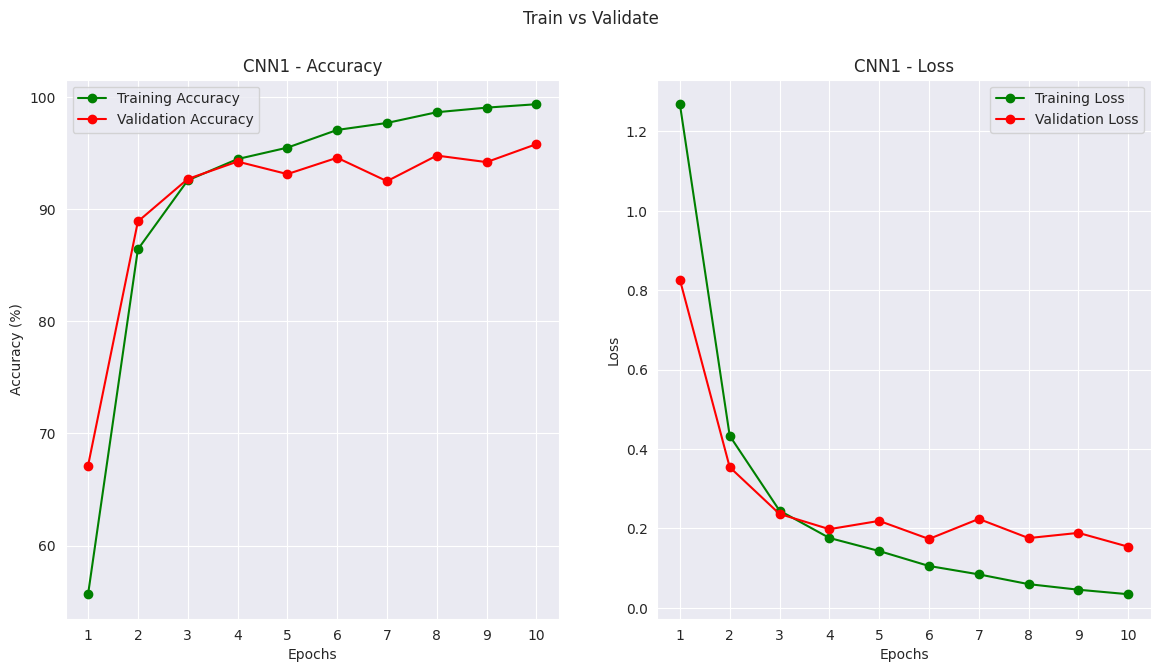

In [ ]:
models = [CNN1()]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()

for model in models:
    optimizer = torch.optim.Adam(model.parameters())
    train_res, valid_res = train_and_validate_model(model, trainloader, testloader, criterion, optimizer, 10, device)
    plot_train_valid_results(train_res, valid_res, type(model).__name__)

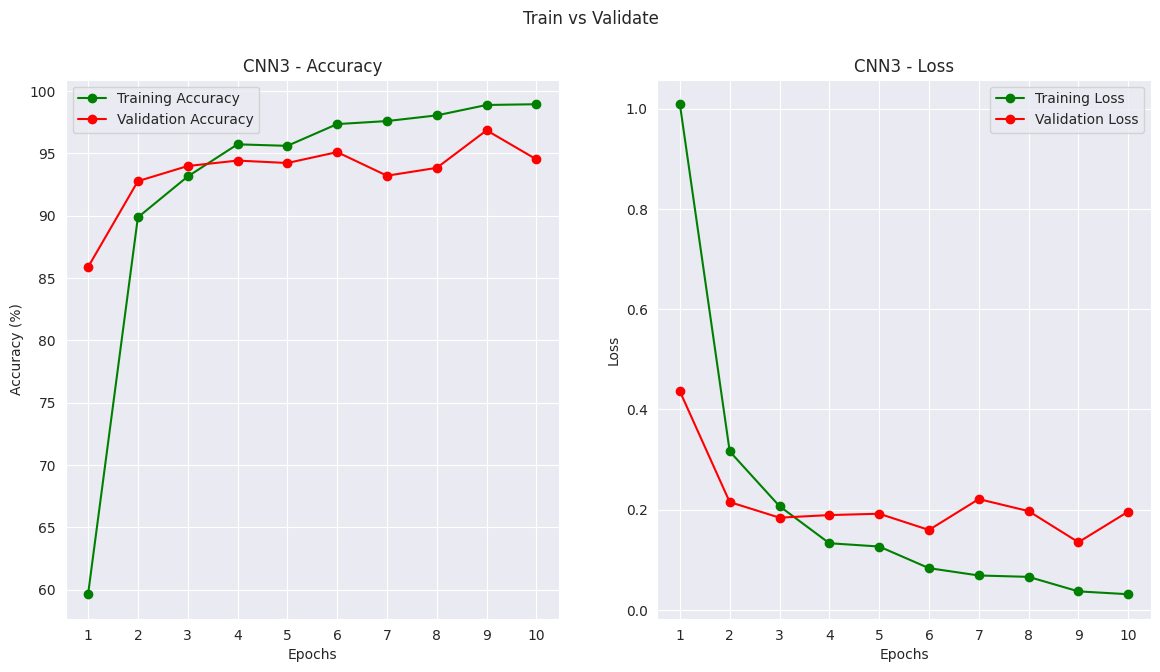

In [ ]:
models = [CNN3()]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()

for model in models:
    optimizer = torch.optim.Adam(model.parameters())
    train_res, test_res = train_and_validate_model(model, trainloader, testloader, criterion, optimizer, 10, device)
    plot_train_valid_results(train_res, test_res, type(model).__name__)

In [ ]:
def train_and_test_model(model, trainloader, testloader, criterion, optimizer, epochs, device):
    model.to(device)
    train_results = {'accuracy': [], 'loss': []}
    test_results = {'accuracy': [], 'loss': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for data, target in trainloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        train_results['loss'].append(train_loss / len(trainloader))
        train_results['accuracy'].append(100 * correct / total)

        # Testing phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in testloader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        test_results['loss'].append(test_loss / len(testloader))
        test_results['accuracy'].append(100 * correct / total)

    return train_results, test_results

In [ ]:
def plot_train_test_results(train_results, test_results, title):
    epochs = range(1, len(train_results['accuracy']) + 1)

    plt.figure(figsize=(14, 7))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_results['accuracy'], 'go-', label='Training Accuracy')
    plt.plot(epochs, test_results['accuracy'], 'ro-', label='Testing Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_results['loss'], 'go-', label='Training Loss')
    plt.plot(epochs, test_results['loss'], 'ro-', label='Testing Loss')
    plt.title(title + ' - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)

    plt.suptitle('Train vs Test')
    plt.show()

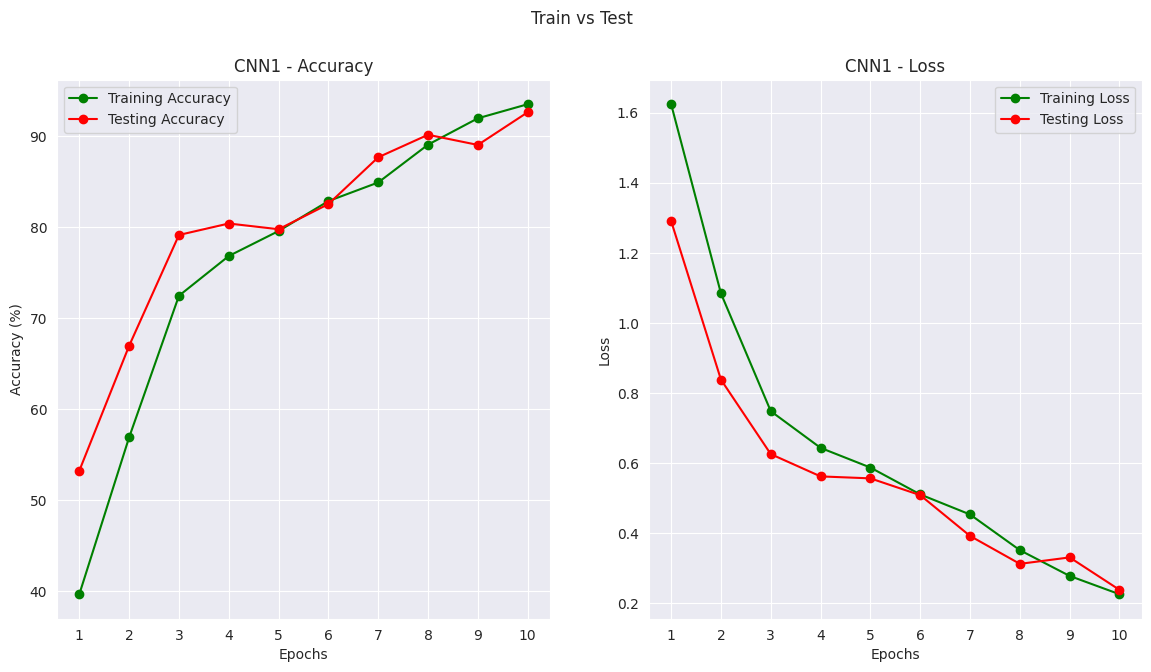

In [ ]:
models = [CNN1()]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()

for model in models:
    optimizer = torch.optim.Adam(model.parameters())
    train_res, test_res = train_and_test_model(model, trainloader, testloader, criterion, optimizer, 10, device)
    plot_train_test_results(train_res, test_res, type(model).__name__)

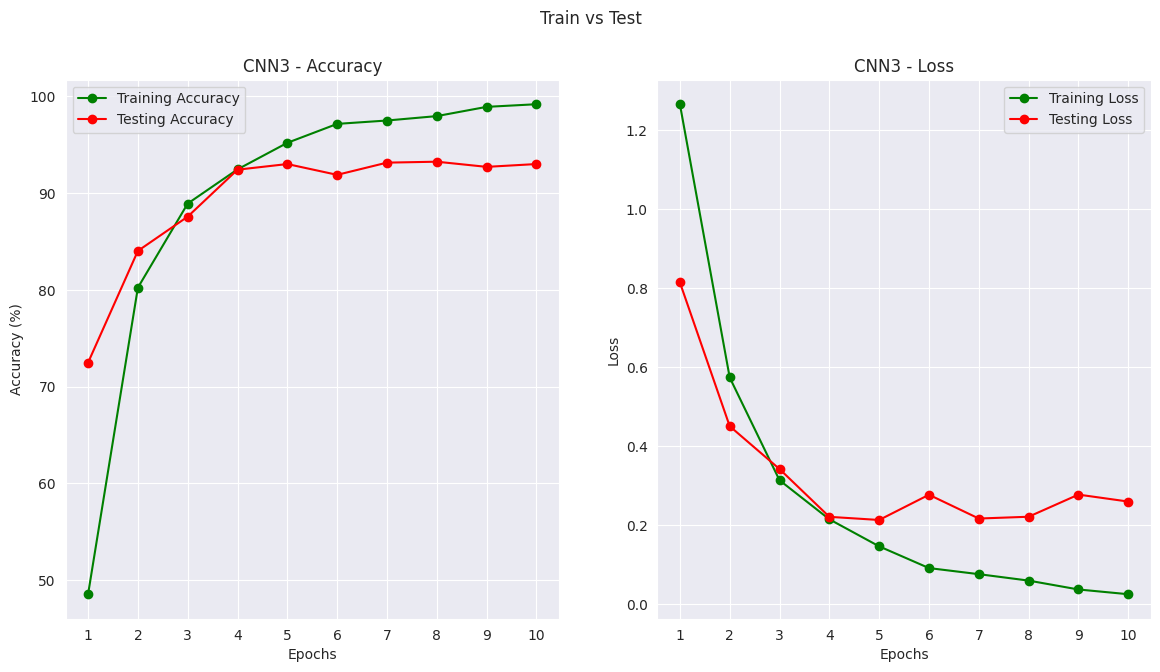

In [ ]:
models = [CNN3()]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()

for model in models:
    optimizer = torch.optim.Adam(model.parameters())
    train_res, test_res = train_and_test_model(model, trainloader, testloader, criterion, optimizer, 10, device)
    plot_train_test_results(train_res, test_res, type(model).__name__)

In [ ]:
class CNN1A(nn.Module):
    def __init__(self):
        super(CNN1A, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.attention = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=1)  # Attention layer
        self.fc1 = nn.Linear(8 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 5)  # Fixed number of classes

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        attention_map = self.attention(x)
        attention_map = torch.sigmoid(attention_map)
        x = x * attention_map
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x, attention_map


In [ ]:
def evaluate_model_with_attention(model, testloader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_loss = 0.0
    test_acc = 0.0
    all_attention_maps = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            logits, attention_map = model(images)
            loss = criterion(logits, labels)

            test_loss += loss.item()
            test_acc += (logits.argmax(dim=1) == labels).float().mean().item()
            all_attention_maps.extend(attention_map.cpu())
            all_labels.extend(labels.cpu())
            all_preds.extend(logits.argmax(dim=1).cpu())

    test_loss /= len(testloader)
    test_acc /= len(testloader)

    return test_loss, test_acc, all_attention_maps, all_labels, all_preds



In [ ]:
from collections import defaultdict

def visualize_attention_per_class(testloader, attention_maps, attention_labels, predictions, reverse_label_mapping):
    class_attention = defaultdict(list)

    for attention_map, label, pred in zip(attention_maps, attention_labels, predictions):
        class_attention[label.item()].append((attention_map, pred))

    for class_id, attentions in class_attention.items():
        class_name = reverse_label_mapping[class_id]
        print(f"{class_name}:")
        plt.figure(figsize=(10, 10))
        for i in range(min(5, len(attentions))):  # Show up to 5 attention maps per class.
            attention_map, pred = attentions[i]
            pred_name = reverse_label_mapping[pred.item()]
            plt.subplot(1, 5, i + 1)
            attention_map = attention_map.detach().cpu().numpy()
            if len(attention_map.shape) == 3:
                attention_map = attention_map[0] 
            plt.imshow(attention_map, cmap='jet')
            plt.title(f'True: {class_name}\nPred: {pred_name}')
            plt.axis('off')
        plt.show()


In [ ]:
def train_and_evaluate_model_attentionmap(model, num_epochs, trainloader, validloader, testloader, criterion, optimizer, reverse_label_mapping):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
      
        model.train()
        running_loss = 0.0
        running_acc = 0.0

        for images, labels in trainloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits, _ = model(images)  
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += get_accuracy(logits, labels)

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = running_acc / len(trainloader)

   
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for images, labels in validloader:
                images = images.to(device)
                labels = labels.to(device)

                logits, _ = model(images)  
                loss = criterion(logits, labels)

                val_loss += loss.item()
                val_acc += get_accuracy(logits, labels)

        val_loss /= len(validloader)
        val_acc /= len(validloader)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Test phase and visualization of attention maps by class
    test_loss, test_acc, attention_maps, attention_labels, predictions = evaluate_model_with_attention(model, testloader, criterion)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    visualize_attention_per_class(testloader, attention_maps, attention_labels, predictions, reverse_label_mapping)



Epoch 1/10, Train Loss: 1.3865, Train Acc: 42.9531, Val Loss: 0.9633, Val Acc: 58.4135
Epoch 2/10, Train Loss: 0.6997, Train Acc: 75.4025, Val Loss: 0.4959, Val Acc: 85.2163
Epoch 3/10, Train Loss: 0.4254, Train Acc: 86.7385, Val Loss: 0.3201, Val Acc: 91.4663
Epoch 4/10, Train Loss: 0.3127, Train Acc: 90.3044, Val Loss: 0.3537, Val Acc: 89.5433
Epoch 5/10, Train Loss: 0.2484, Train Acc: 92.4130, Val Loss: 0.2501, Val Acc: 92.5481
Epoch 6/10, Train Loss: 0.2110, Train Acc: 93.2787, Val Loss: 0.2332, Val Acc: 92.0072
Epoch 7/10, Train Loss: 0.1815, Train Acc: 93.9452, Val Loss: 0.2376, Val Acc: 92.9688
Epoch 8/10, Train Loss: 0.1658, Train Acc: 95.0091, Val Loss: 0.1954, Val Acc: 94.5913
Epoch 9/10, Train Loss: 0.1429, Train Acc: 95.5845, Val Loss: 0.1838, Val Acc: 94.7115
Epoch 10/10, Train Loss: 0.1357, Train Acc: 95.7504, Val Loss: 0.2077, Val Acc: 93.3894
Test Loss: 0.2057, Test Accuracy: 0.9309
basophil:


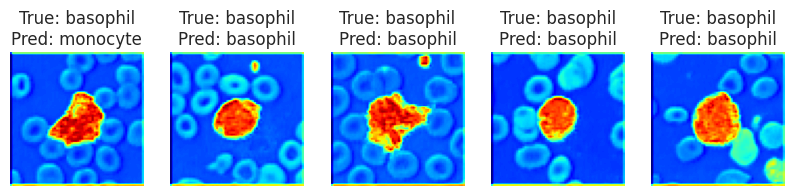

neutrophil:


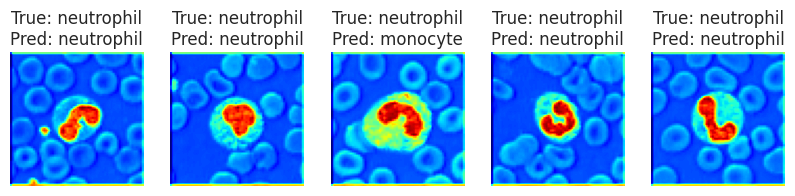

eosinophil:


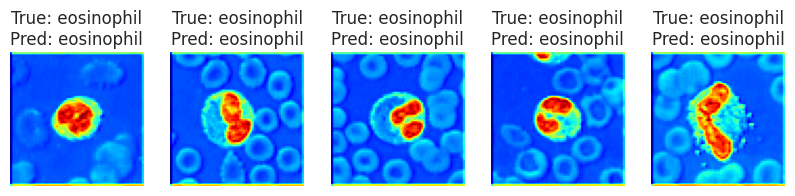

monocyte:


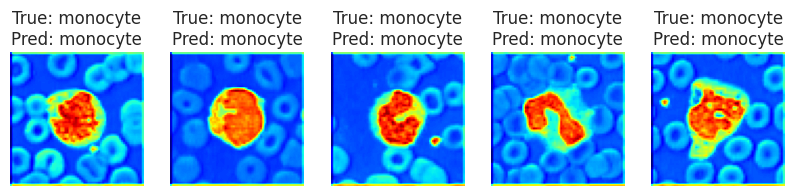

lymphocyte:


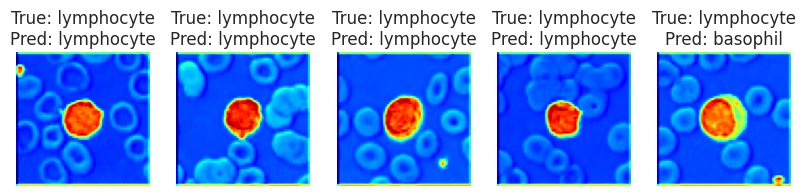

In [ ]:
model = CNN1A()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Definition of loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Definition of reverse_label_mapping
new_reverse_label_mapping_scale = {0: 'monocyte', 1: 'lymphocyte', 2: 'basophil', 3: 'neutrophil', 4: 'eosinophil'}

# Model training and evaluation
train_and_evaluate_model_attentionmap(model, 10, trainloader, validloader, testloader, criterion, optimizer, new_reverse_label_mapping_scale)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_attention_percentages(image, attention_map, true_label, pred_label, percentages=[75, 50, 25, 20, 10, 5]):
    # We convert the attention map to a numpy array
    attention_map = attention_map.detach().cpu().numpy()
    if len(attention_map.shape) == 3:
        attention_map = attention_map[0]

    # We flatten the attention map and get the indices sorted by decreasing importance
    flat_attention = attention_map.flatten()
    sorted_indices = np.argsort(flat_attention)[::-1]

    fig, axes = plt.subplots(1, len(percentages) + 1, figsize=(15, 5))

    # Original image with true and predicted labels
    axes[0].imshow(image.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title(f'True: {true_label}\nPred: {pred_label}')
    axes[0].axis('off')

    for i, percentage in enumerate(percentages):
        # Number of pixels to be maintained
        num_pixels = int(percentage / 100.0 * len(flat_attention))

        # We create a mask of zero and set the top pixels to 1
        mask = np.zeros_like(flat_attention)
        mask[sorted_indices[:num_pixels]] = 1
        mask = mask.reshape(attention_map.shape)

        # We apply the mask to the image
        mask_tensor = torch.tensor(mask).unsqueeze(0).to(image.device)
        masked_image = image * mask_tensor

        # Make sure the masked image has three dimensions
        if masked_image.dim() == 5:
            masked_image = masked_image.squeeze(0).squeeze(0)

        # We display the masked image
        axes[i + 1].imshow(masked_image.permute(1, 2, 0).cpu().numpy())
        axes[i + 1].set_title(f'{percentage}%')
        axes[i + 1].axis('off')

    plt.show()



In [ ]:
def visualize_attention_for_classes(testloader, attention_maps, attention_labels, predictions, reverse_label_mapping, percentages=[75, 50, 25, 20, 10, 5]):
    class_attention = defaultdict(list)

    for attention_map, label, pred in zip(attention_maps, attention_labels, predictions):
        class_attention[label.item()].append((attention_map, pred))

    for class_id, attentions in class_attention.items():
        class_name = reverse_label_mapping[class_id]
        attention_map, pred = attentions[0]  # Get the first attention map for the class
        pred_name = reverse_label_mapping[pred.item()]

        # Find the corresponding image in the testloader
        for images, labels in testloader:
            for j in range(labels.size(0)):
                if labels[j].item() == class_id:
                    image = images[j]
                    plot_attention_percentages(image, attention_map.unsqueeze(0), class_name, pred_name, percentages)
                    break
            else:
                continue
            break



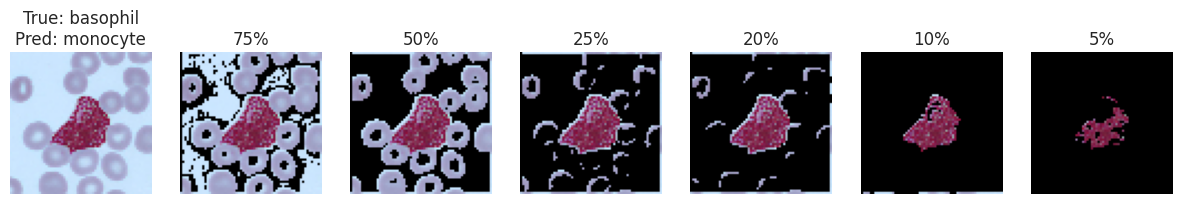

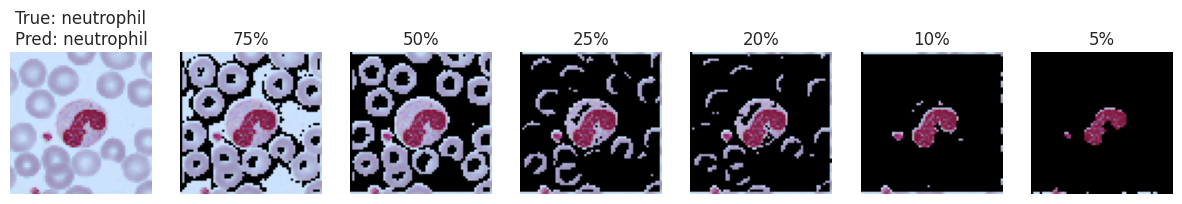

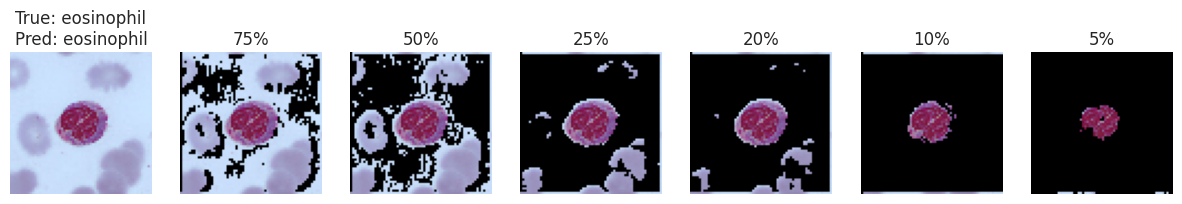

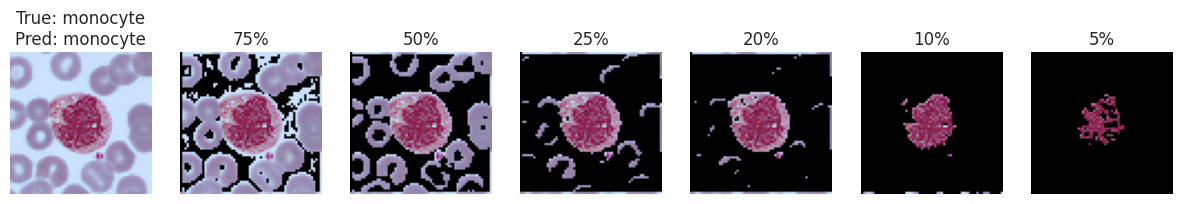

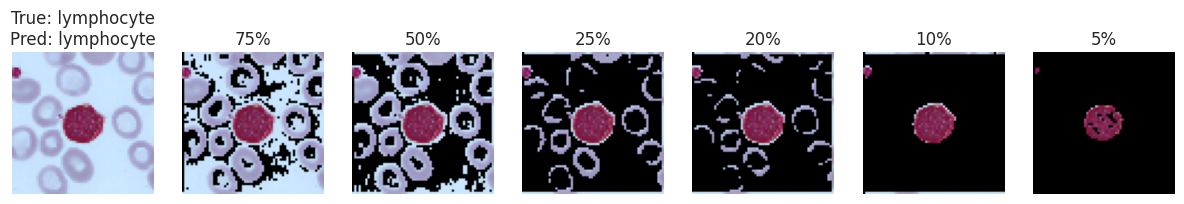

In [ ]:
test_loss, test_acc, attention_maps, attention_labels, predictions = evaluate_model_with_attention(model, testloader, criterion)
visualize_attention_for_classes(testloader, attention_maps, attention_labels, predictions, new_reverse_label_mapping_scale)

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def get_misclassifications(labels, predictions):
    misclassified_labels = []
    misclassified_predictions = []

    for label, prediction in zip(labels, predictions):
        if label != prediction:
            misclassified_labels.append(label)
            misclassified_predictions.append(prediction)

    return misclassified_labels, misclassified_predictions


def count_misclassifications(misclassified_labels, reverse_label_mapping):
    misclassification_counts = defaultdict(int)

    for label in misclassified_labels:
        class_name = reverse_label_mapping[label.item()]
        misclassification_counts[class_name] += 1

    return misclassification_counts


def plot_misclassifications_distribution(misclassification_counts):
    classes = list(misclassification_counts.keys())
    counts = list(misclassification_counts.values())

    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Misclassifications')
    plt.title('Distribution of Misclassifications by Class')
    plt.show()



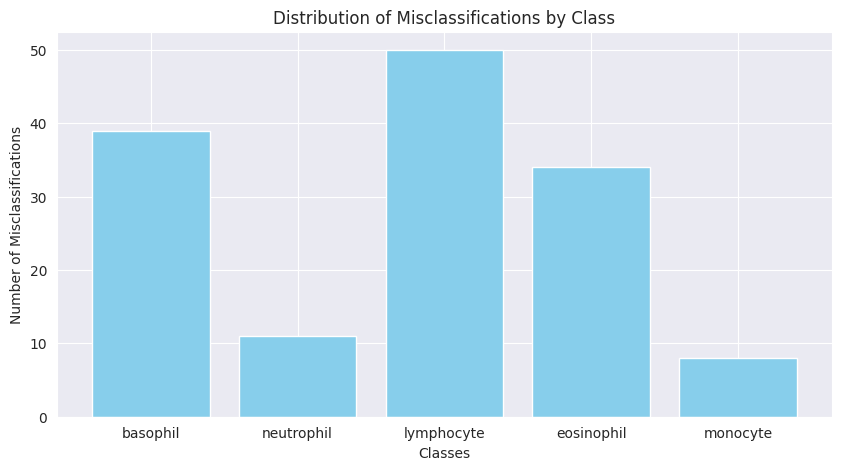

In [ ]:
# Get the incorrect predictions
misclassified_labels, misclassified_predictions = get_misclassifications(attention_labels, predictions)

# Count incorrect predictions by class
misclassification_counts = count_misclassifications(misclassified_labels, new_reverse_label_mapping_scale)

# Create a barplot of incorrect predictions
plot_misclassifications_distribution(misclassification_counts)